# Set up 


In [3]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import sys
import scipy.optimize as optimize
import threading
from scipy.optimize import LinearConstraint
from datetime import datetime

In [4]:
path="./" + "sidedata/"
filename = path + "Alldata2.csv"

df=pd.read_csv(filename, index_col=None)

df = df[df["FileCondi"]!="CMat"]
df['Probtype'] = np.where(df['Stimkind']==1, "CM",
                   np.where(df['Stimkind']==0, "AN",
                   np.where(df['Stimkind']==3, 'VM',"wrong")))

df['Oldnew'] = np.where(df['Old']==1, "old",
                   np.where(df['Old']==2, "new","wrong"))
df['Error'] = 1-df['Correctness']
df_giver = df
df0=df.copy()# = df.copy()
# df_giver.columns=df_giver.columns.droplevel(1)
df_org = df[df['RT']<2000]
df = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","Error","FileCondi"])[["RT"]].agg(["mean"])
# df[["Correctness","Error"]]
# df.groupby("Error")
df.index.name = 'Setsize'
df.reset_index(inplace=True)
# df["Error"]


df_err = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["Error"]].agg(["mean"]).reset_index()
df_crt = df_org[df_org["Error"]==0].\
groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["RT"]].agg(["mean"]).reset_index()

df_err.columns = df_err.columns.droplevel(1)
df_crt.columns = df_crt.columns.droplevel(1)

df_err = df_err.reset_index()
df_crt = df_crt.reset_index()
# df_err.reindex(np.arange(1,df_err.shape[0]))
# df_crt.reindex(np.arange(1,df_crt.shape[0]))

In [5]:
# df.columns=df.columns.droplevel(1)
df.to_csv("df.csv")
df_err.to_csv("df_err.csv")
df_crt.to_csv("df_crt.csv")
df_org.to_csv("df_org.csv")

# R funcitons

In [3]:
%get df_giver --from Python3
# library(plyr)
library(dplyr)
library(ggplot2)
library(lattice)
library(Rmisc)
library(stringr)
library(tidyr)
library(cowplot)
library(plotly)
# source("functions_fromr.r")
d=df_giver


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: plyr

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: 'plyr'


The following objects are masked from 'package:dplyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



Attaching package: 'cowplot'


The following object is masked from 'package:ggplot2':

    ggsave



Attaching package: 'plotly'


The following objects are masked from 'package:plyr':

    arrange, mutate, rename, summarise


The following object is mas

   Length     Class      Mode 
      168 character character 

Automatically converting the following non-factors to factors: Subnum, Old, Setsize, Stimkind

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
"Removed 56 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 3 rows containing missing values (geom_point)."
Automatically converting the following non-factors to factors: Subnum, Old, Setsize, Stimkind

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
"Removed 56 rows containing missing values (geom_errorbar)."
Automatically converting the following non-factors to factors: Subnum, Old, Setsize, Stimkind

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



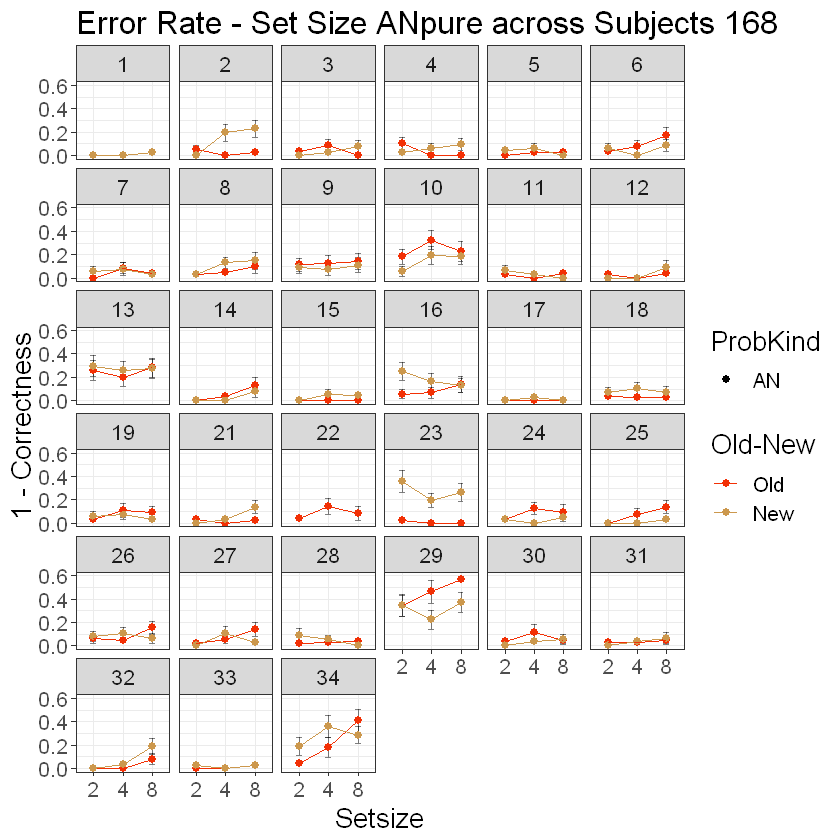

Warning message:
"Removed 106 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."
Automatically converting the following non-factors to factors: Subnum, Old, Setsize, Stimkind

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



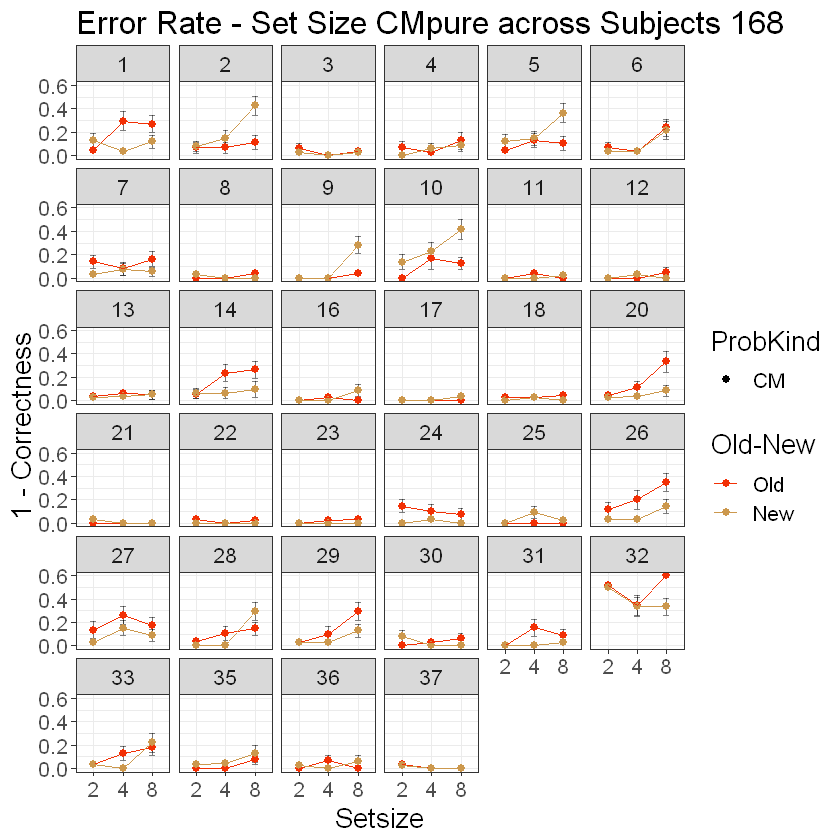

Warning message:
"Removed 115 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 5 rows containing missing values (geom_point)."
Automatically converting the following non-factors to factors: Subnum, Old, Setsize, Stimkind

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



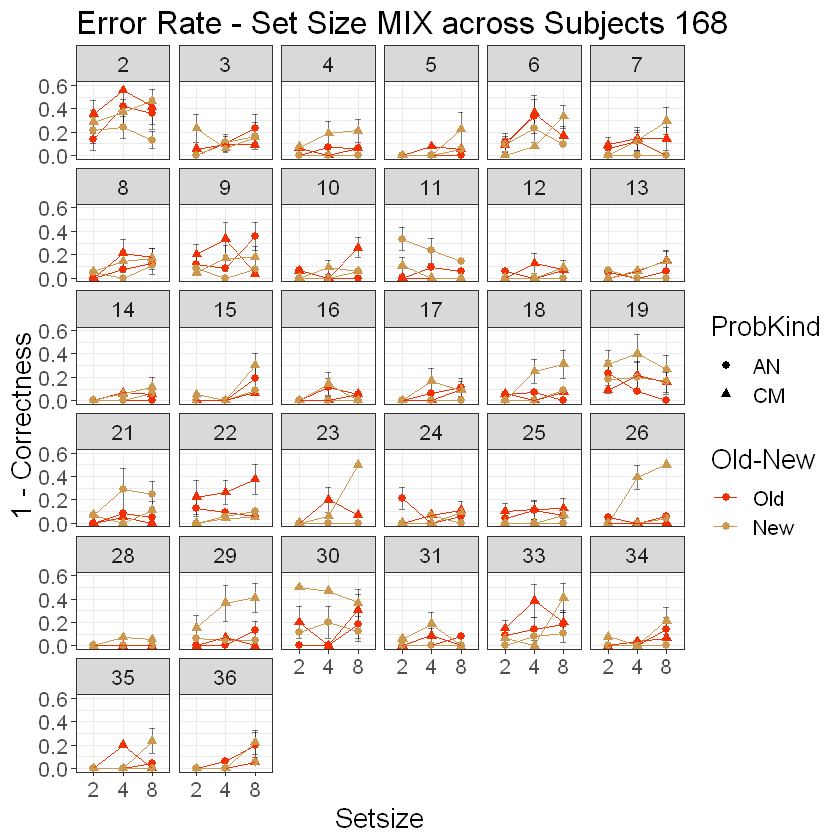

Warning message:
"Removed 36 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."


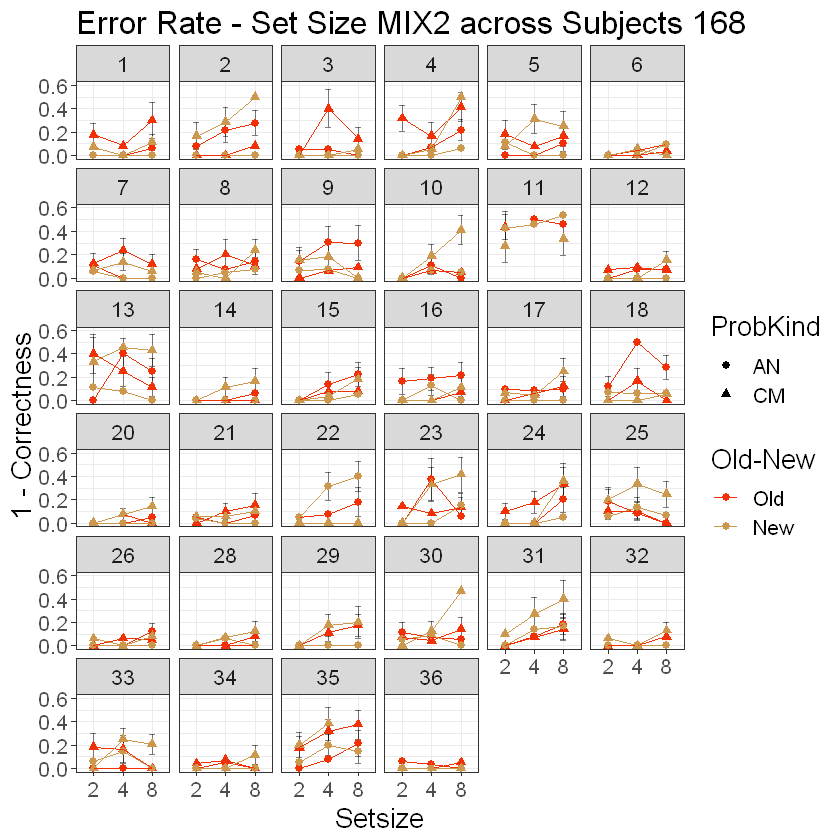

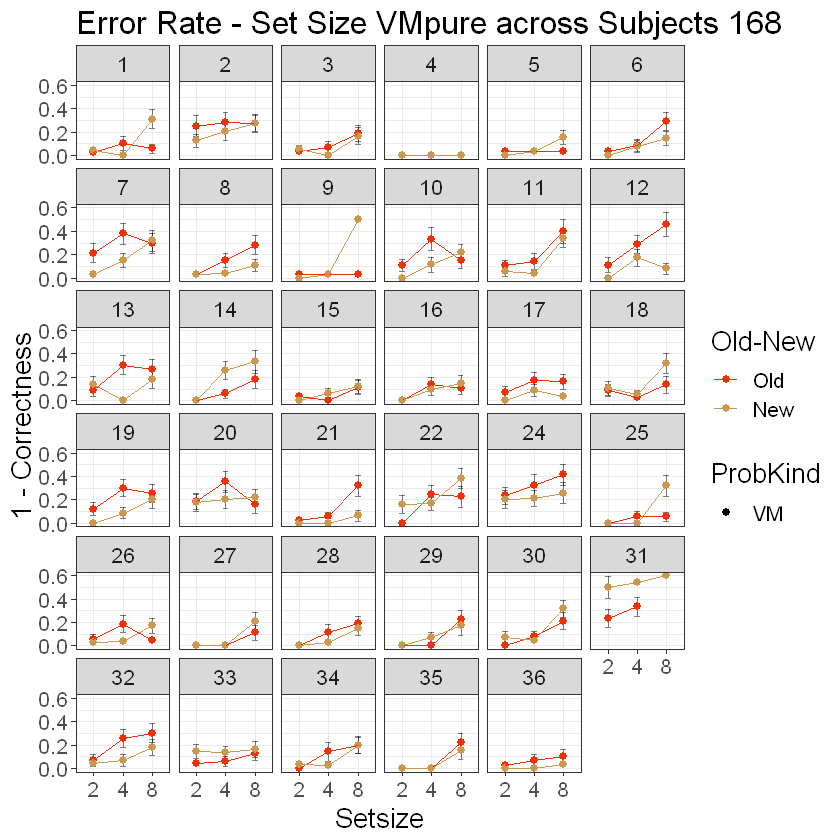

In [7]:
dx=d%>%group_by(Subnum,FileCondi) %>%dplyr::summarise(n())
summary(dx$FileCondi)
all_subnum=length(dx$Subnum)
p.ERdif=function(condition,d){
  tit=paste(condition,'across Subjects',all_subnum)
  d0= d%>% filter(FileCondi==condition)
  dase=summarySEwithin(data=d0,measurevar = "Correctness",withinvars =
                         c("Subnum","Old","Setsize","Stimkind"))
  # print(dase)
  da1se=dase
  p=ggplot(data=da1se,aes(Setsize,1-Correctness))+
    geom_errorbar(aes(ymin=(1-Correctness)-se, ymax=(1-Correctness)+se), width=.2,
                 position=position_dodge(.9),alpha=0.5) +
  geom_point(aes(color=as.factor(Old),shape=as.factor(Stimkind),group=Old),size=2)+
  geom_line(aes(color=as.factor(Old),#linetype=as.factor(FileCondi),
                group=interaction(Old,Stimkind)))+
  scale_color_manual(name="Old-New",#breaks=c(1,0),
                      labels=c(`1`="Old", `2`="New"),
                      values=c("#F23005","#CC984D"))+
  scale_shape_discrete(
    name="ProbKind",labels = c(`1`="CM",`0`="AN",`3`="VM"))+
  # scale_linetype_discrete(
  #   name="Condition")+
  ggtitle(paste("Error Rate - Set Size",tit))+
     theme_bw()+
    theme(text=element_text(size=16))+
    # ylim(700,1550)+
  facet_wrap(Subnum~.)+
    scale_y_continuous("Probability of Error")+
    ylim(c(0,0.6))
    print(p)
  
   return (p)
}
for( iname in levels(as.factor(d$FileCondi))){
#     print(iname)
    p.ERdif(iname,d) #11.... 
}

#ANpure : 29, 34?
#CMpure: 32?
#Mix2: 11
#VMpure 31



Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
"Removed 16 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 7 rows containing missing values (geom_point)."
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
"Removed 12 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 5 rows containing missing values (geom_point)."
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



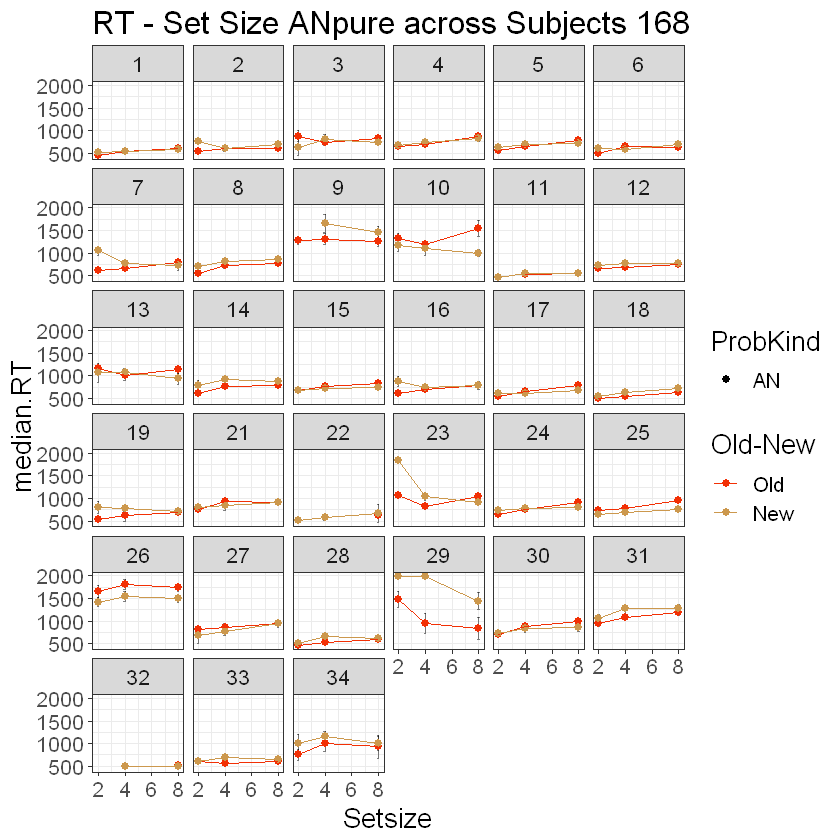

Warning message:
"Removed 18 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



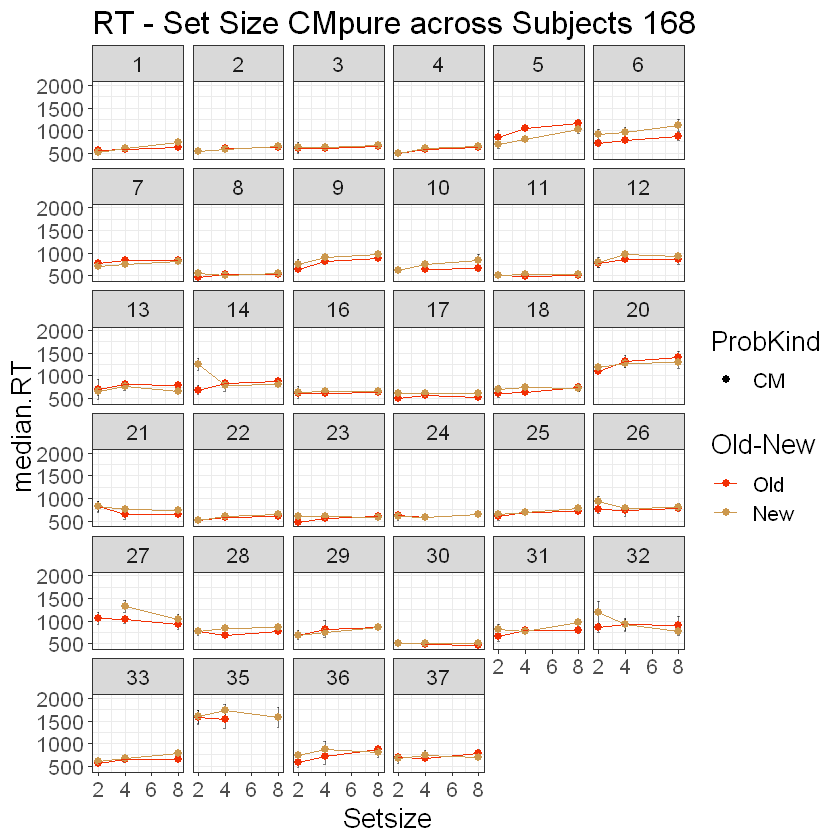

Warning message:
"Removed 21 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 3 rows containing missing values (geom_point)."
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



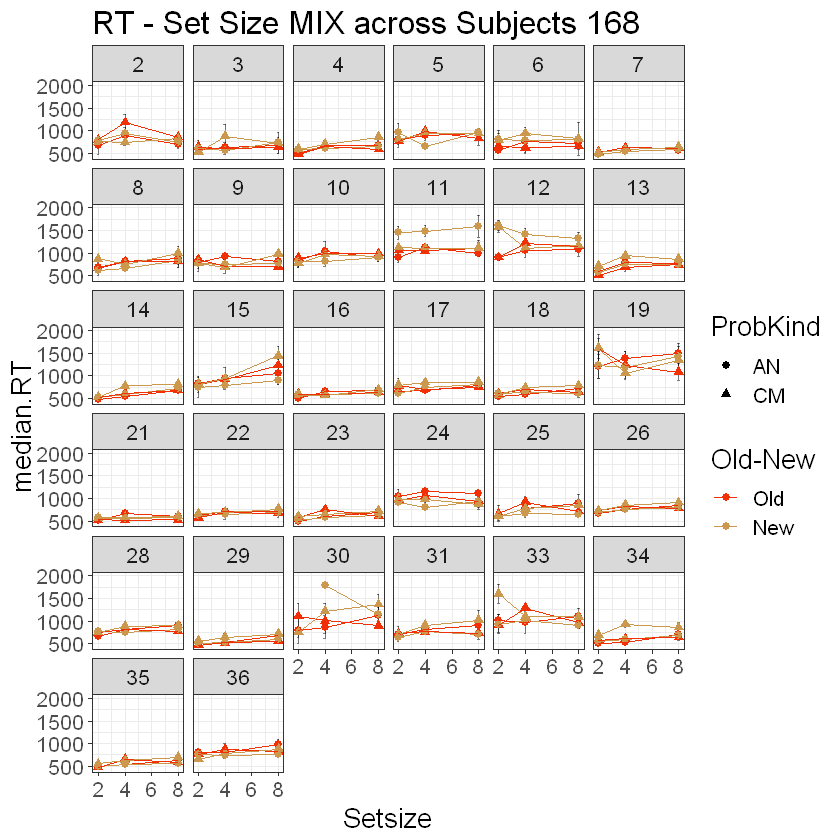

Warning message:
"Removed 10 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."


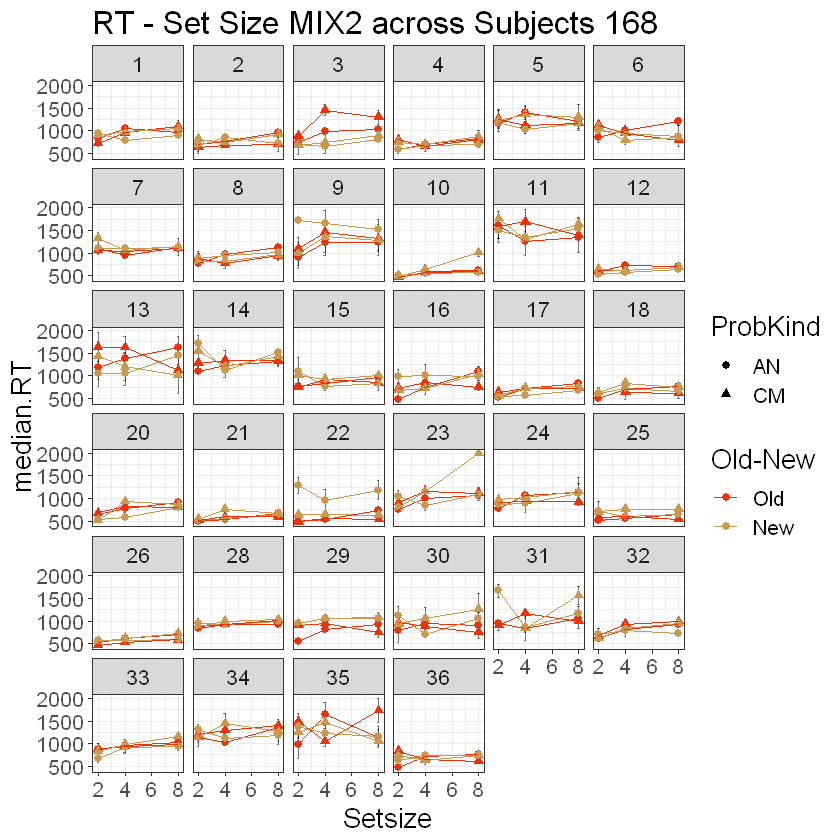

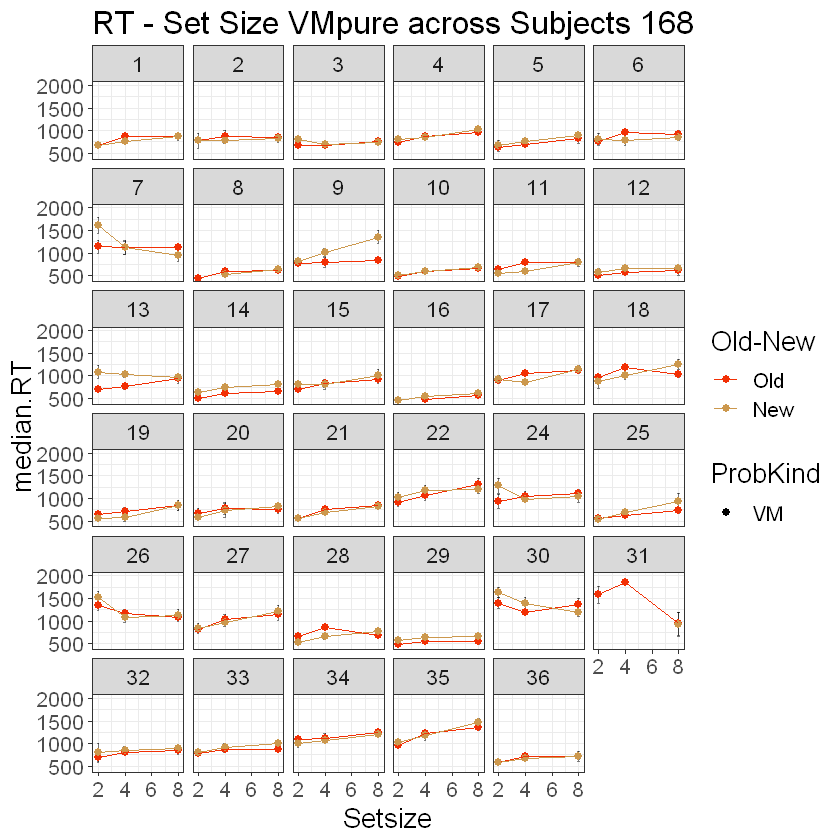

In [9]:
p.RTdif=function(condition,d){
  tit=paste(condition,'across Subjects',all_subnum)
  
  # condition="ANpure"
  d0= d%>% filter(FileCondi==condition)
  dase=d0 %>% group_by(Subnum,Old,Setsize,Stimkind,Correctness) %>%
    dplyr::summarise(median.RT=median(RT),se=sd(RT)/sqrt(n()))

  # print(dase)
  da1se=dase %>% filter(Correctness==1)
  p=ggplot(data=da1se,aes(Setsize,median.RT))+
    geom_errorbar(aes(ymin=(median.RT)-se, ymax=(median.RT)+se), width=.2,
                 position=position_dodge(.9),alpha=0.5) +
  geom_point(aes(color=as.factor(Old),shape=as.factor(Stimkind),group=Old),size=2)+
  geom_line(aes(color=as.factor(Old),#linetype=as.factor(FileCondi),
                group=interaction(Old,Stimkind)))+
  scale_color_manual(name="Old-New",#breaks=c(1,0),
                      labels=c(`1`="Old", `2`="New"),
                      values=c("#F23005","#CC984D"))+
  scale_shape_discrete(
    name="ProbKind",labels = c(`1`="CM",`0`="AN",`3`="VM"))+
  # scale_linetype_discrete(
  #   name="Condition")+
  ggtitle(paste("RT - Set Size",tit))+
     theme_bw()+
    theme(text=element_text(size=16))+
    # ylim(700,1550)+
  facet_wrap(Subnum~.)+
    scale_y_continuous("Response Time")+
    ylim(c(450,2000))
    print(p)
   return (p)
}
for( iname in levels(as.factor(d$FileCondi))){
    p.RTdif(iname,d)
}

#ANpure : 29, 34?
#CMpure: 32?
#Mix2: 11 - yeah maybe
#VMpure 31 - definatly


In [24]:
d_clean = d%>% filter(!(FileCondi=="ANpure" & Subnum==29)) %>%
    filter(!(FileCondi=="CMpure" & Subnum==32)) %>%
    filter(!(FileCondi=="MIX2" & Subnum==11) )%>%
    filter(!(FileCondi=="VMpure" & Subnum==31))


Automatically converting the following non-factors to factors: FileCondi, Old, Setsize, Stimkind

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



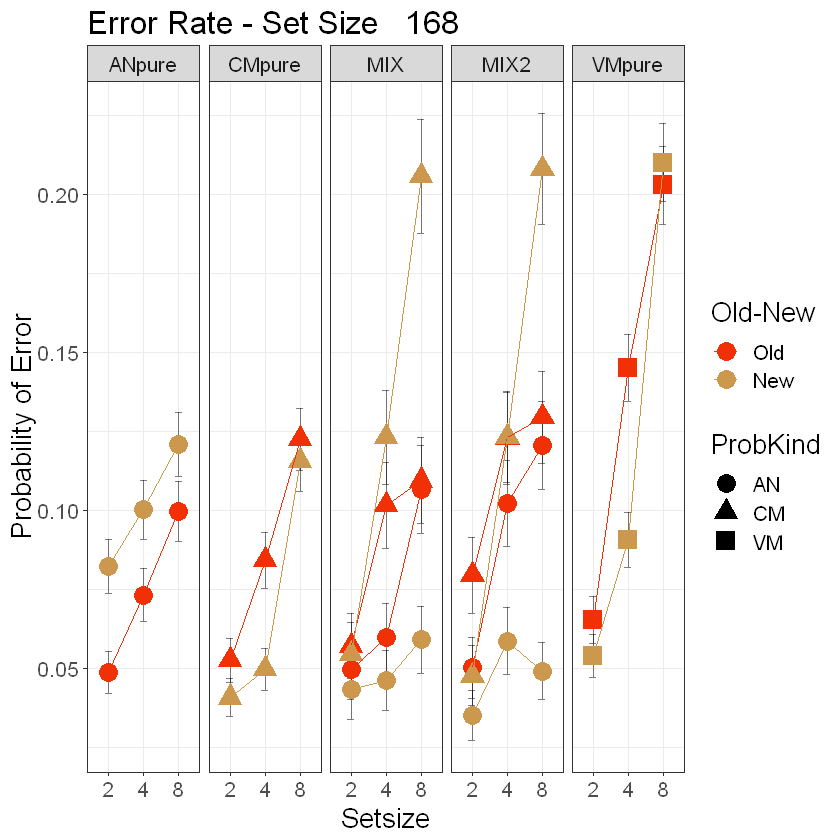

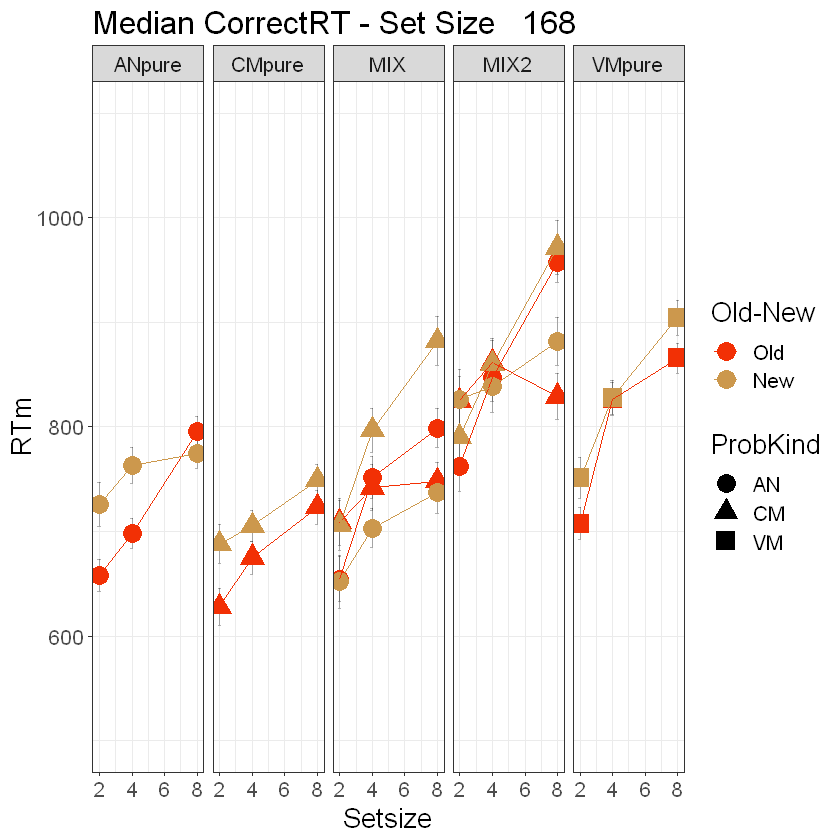

In [27]:
p.medianRT=function(d,tit,BlockFilter){
  cols <- c(`1`=1,`0`=2,`3`=3)
  
  tit=paste(' ',all_subnum," ",tit)
  dase = d %>% filter(Block %in% BlockFilter) %>%
  group_by(FileCondi,Correctness,  Old,Setsize, Stimkind) %>%
  dplyr::summarize(RTm= median(RT),
            se =sd(RT)/sqrt(n()))
  # print(dase)
  da1se=subset(dase,Correctness==1)#;da1se
  p=ggplot(data=da1se,aes(Setsize,RTm))+
    geom_errorbar(aes(ymin=RTm-se, ymax=RTm+se), width=.2,
                 position=position_dodge(.9),alpha=0.3) +
  geom_point(aes(color=as.factor(Old),shape=as.factor(Stimkind),group=Old),size=5)+
  geom_line(aes(color=as.factor(Old),#linetype=as.factor(FileCondi),
                group=interaction(Old,Stimkind)))+
  scale_color_manual(name="Old-New",#breaks=c(1,0),
                      labels=c(`1`="Old", `2`="New"),
                      values=c("#F23005","#CC984D"))+
  scale_shape_discrete(
    name="ProbKind",labels = c(`1`="CM",`0`="AN",`3`="VM"))+
  # scale_linetype_discrete(
  #   name="Condition")+
  ggtitle(paste("Median CorrectRT - Set Size",tit))+
     theme_bw()+
    theme(text=element_text(size=16))+
    ylim(500,1100)+
  facet_wrap(FileCondi~.,ncol=6)
  # scale_colour_manual(name="Error Bars",values=cols, guide = guide_legend(shape = NULL,colour = NULL)) + 
  # scale_shape_manual(name="Bar",values=cols, guide="none") 
  
  return(p)
}
p.ER=function(d,tit,BlockFilter){
  tit=paste(' ',all_subnum," ",tit)
  d0= d %>% filter(Block %in% BlockFilter)
  dase=summarySEwithin(data=d0,measurevar = "Correctness",withinvars =
                         c("FileCondi","Old","Setsize","Stimkind"))
  # print(dase)
  da1se=dase
  p=ggplot(data=da1se,aes(Setsize,1-Correctness))+
    geom_errorbar(aes(ymin=(1-Correctness)-se, ymax=(1-Correctness)+se), width=.2,
                 position=position_dodge(.9),alpha=0.5) +
  geom_point(aes(color=as.factor(Old),shape=as.factor(Stimkind),group=Old),size=5)+
  geom_line(aes(color=as.factor(Old),#linetype=as.factor(FileCondi),
                group=interaction(Old,Stimkind)))+
  scale_color_manual(name="Old-New",#breaks=c(1,0),
                      labels=c(`1`="Old", `2`="New"),
                      values=c("#F23005","#CC984D"))+
  scale_shape_discrete(
    name="ProbKind",labels = c(`1`="CM",`0`="AN",`3`="VM"))+
  # scale_linetype_discrete(
  #   name="Condition")+
  ggtitle(paste("Error Rate - Set Size",tit))+
     theme_bw()+
    theme(text=element_text(size=16))+
    ylim(0,0.25)+
  facet_wrap(FileCondi~.,ncol=6)+
    scale_y_continuous("Probability of Error")
  return(p)
}
p3=p.ER(d," ",2:9)
p3
p2=p.medianRT(d," ",2:9)
p2

In [ ]:
write.csv(file="Alldata2.csv",d)
d%>%filter(FileCondi=="MIX")

In [4]:
# levels(as.factor(df_giver$FileCondi))
files = c('ANpure' ,'CMpure', 'MIX', 'MIX2', 'VMpure')
c("alpha","beta","s",paste("c",files,sep="_"),paste(rep(c("BDDo","BDDn"),5),rep(files,each=2),sep="_"),
 "t0","t0an","kappa",
 'F_ANpure_AN_oldiold_oldinew',
 'F_CMpure_CM_oldiold_oldinew',
 'L_CMpure_CM_oldiold_newinew',
 'L_CMpure_CM_oldinew_newiold',
 'F_VMpure_VM_oldiold_oldinew',
 'L_VMpure',
 'F_MIX_CM_oldiold_oldinew',
 'L_MIX_CM_oldiold_newinew',
 'L_MIX_CM_oldinew_newiold',
 'F_MIX_AN_oldiold_oldinew',
 'F_MIX2_CM_oldiold_oldinew',
 'L_MIX2_CM_oldiold_newinew',
 'L_MIX2_CM_oldinew_newiold',
 'F_MIX2_AN_oldiold_oldinew')


[1] "alpha"                       "beta"                       
 [3] "s"                           "c_ANpure"                   
 [5] "c_CMpure"                    "c_MIX"                      
 [7] "c_MIX2"                      "c_VMpure"                   
 [9] "BDDo_ANpure"                 "BDDn_ANpure"                
[11] "BDDo_CMpure"                 "BDDn_CMpure"                
[13] "BDDo_MIX"                    "BDDn_MIX"                   
[15] "BDDo_MIX2"                   "BDDn_MIX2"                  
[17] "BDDo_VMpure"                 "BDDn_VMpure"                
[19] "t0"                          "t0an"                       
[21] "kappa"                       "F_ANpure_AN_oldiold_oldinew"
[23] "F_CMpure_CM_oldiold_oldinew" "L_CMpure_CM_oldiold_newinew"
[25] "L_CMpure_CM_oldinew_newiold" "F_VMpure_VM_oldiold_oldinew"
[27] "L_VMpure"                    "F_MIX_CM_oldiold_oldinew"   
[29] "L_MIX_CM_oldiold_newinew"    "L_MIX_CM_oldinew_newiold"   
[31] "F_MIX_AN_oldiold_oldinew"    "F_MIX2_CM_oldiold_oldinew"  
[33] "L_MIX2_CM_oldiold_newinew"   "L_MIX2_CM_oldinew_newiold"  
[35] "F_MIX2_AN_oldiold_oldinew"

    for icondi in filecondis:
        x=threading.Thread(target=work_thread_p,args=(icondi,))
        threads.append(x)
        x.start()
    for icondi, thread in enumerate(threads):
        thread.join()

# Some global setting

In [6]:
global vary_ss, give_c2
vary_ss=0
give_c2=0

global nameset,is_search_allcondi_besideCMat,search_MIX1
is_search_allcondi_besideCMat=0
search_MIX1 = 1
search_MIX2 = 1
nameset = df_org["FileCondi"].astype("category").cat.categories.to_numpy()

# ALL Parameter

In [30]:
global alpha, beta, s, c ,Old_crit ,New_crit ,\
    t0 ,kao , F, L, c2
  
alpha={}; beta ={}; s = {}; F = {}; L = {}; c={}; t0={}; Old_crit={}; New_crit={}


# boost = 1.05
alpha["all"] = 0.19
# alpha['CM'] = 0.1969 
# alpha['VM'] = 0.1969 
# alpha["AN"]=0.84

beta["all"] =1.2
# beta['CM'] = 1.228
# beta['VM'] = 1.228
# beta["AN"]= 1.708

s["all"]=0.01
s["ss24"]=0.01
s["ss8"]=0.01
# s["AN"] = 0.01
# s["CM"] = 0.02
# s["VM"] = 0.02
c["ANpure"] = 0.3938
c["CMpure"] = 0.3938
c["VMpure"] = 0.3938
c["MIX"] = 0.3938
c["MIX2"] = 0.3938
# c["CMat"] = 0.3938
c2=0.3
Old_crit["ANpure"] = 1.9197
New_crit["ANpure"] = -2.33
Old_crit["CMpure"] = 1.9197
New_crit["CMpure"] = -2.33
Old_crit["VMpure"] = 1.9197
New_crit["VMpure"] = -2.33
Old_crit["MIX"] = 1.9197
New_crit["MIX"] = -2.33
Old_crit["MIX2"] = 1.9197
New_crit["MIX2"] = -2.33

t0["all"] = 699.98
t0["ann"] =  699.98
kao = 37

#---CM
F["ANpure_AN_oldiold_oldinew"] = 0.2

F["CMpure_CM_oldiold_oldinew"] = 0.2
L["CMpure_CM_oldiold_newinew"] = 0.2
L["CMpure_CM_oldinew_newiold"] = 0

F["VMpure_VM_oldiold_oldinew"] = 0.2
L["VMpure"] = 0.2 

F["MIX_CM_oldiold_oldinew"] = 0.2
L["MIX_CM_oldiold_newinew"] = 0.2
L["MIX_CM_oldinew_newiold"] = 0.2
F["MIX_AN_oldiold_oldinew"] = 0.2

F["MIX2_CM_oldiold_oldinew"] = 0.2
L["MIX2_CM_oldiold_newinew"] = 0.2
L["MIX2_CM_oldinew_newiold"] = 0.2
F["MIX2_AN_oldiold_oldinew"] = 0.2




# Assign LTM global

In [8]:
def assign_LTM_global(Filecondi,item_condi, walk, item):
    
    global F,L,Fnow,Lnow
    if Filecondi != "VMpure":
        if item_condi == "CM":

            if walk+"i"+item == "oldiold" or walk+"i"+item == "oldinew":

                Fnow = F[Filecondi+"_CM_oldiold_oldinew"]
            else: Fnow = 0

            if walk+"i"+item == "oldiold" or walk+"i"+item == "newinew":

                Lnow = L[Filecondi+"_CM_oldiold_newinew"]
            elif walk+"i"+item == "oldinew" or walk+"i"+item == "newiold":

                Lnow = L[Filecondi+"_CM_oldinew_newiold"]
            else: Lnow=0

        elif item_condi == "AN":

            if walk+"i"+item == "oldiold" or walk+"i"+item == "oldinew":

                Fnow = F[Filecondi+"_AN_oldiold_oldinew"]
            else: Fnow=0

            Lnow = 0
            
        else: print("wrong condi 1",Filecondi,item_condi, walk+"i"+item)
            
    elif Filecondi == "VMpure":
        
        if item_condi == "VM":
            if walk+"i"+item == "oldiold" or walk+"i"+item == "oldinew":
                Fnow = F["VMpure_VM_oldiold_oldinew"]
            else: Fnow = 0
        else: print("wrong condi 2")
            
        Lnow = L["VMpure"]
    else:
        print("wrong filecondi")
    
    return(Fnow + Lnow)

assign_LTM_global("MIX","AN","old","old")


0.2

# Calc A (activation)

In [9]:

def calcA(df):

    
    dnow = df
    a = np.zeros((dnow.shape[0], 8))  #activation
    

    betanow=beta["all"] 
    alphanow=alpha["all"]
    
    m = np.array([(j**(-betanow) + alphanow) for j in np.arange(1,9)])
    
    for j in range(1,9):

        indexj = j-1
        
        
        if vary_ss==0:
            
            a[dnow["Lag"]==j,indexj] = m[indexj]
            a[dnow["Lag"]!=j,indexj] = m[indexj] * s["all"]
        else:
            a[np.logical_and(dnow["Lag"]!=j,dnow["Setsize"]!=8),indexj] = m[indexj] * s["ss24"]
            a[np.logical_and(dnow["Lag"]!=j,dnow["Setsize"]==8),indexj] = m[indexj] * s["ss8"]
            a[dnow["Lag"]==j,indexj] = m[indexj]
        
        
#         print(m[indexj] * s["all"])
    for i in range(a.shape[0]): a[i,dnow['Setsize'].iloc[i]:] = 0 #a_ij suit for the correct amount of setsize
    debug = 0
    if debug==1:
        for i in range(a.shape[0]):
            print(i, "begin\n","a is",a[i].round(5),\
                  "\n m is", np.array(m).round(3),"\n Probtype is",\
                  "\n Lag is ",dnow['Lag'].iloc[i],\
                  "\n Setsize is", dnow["Setsize"].iloc[i],\
                  "\n Probtype:",\
                  dnow["Probtype"].iloc[i],\
                  "\n Oldnew: ",dnow["Oldnew"].iloc[i],\
                  "\n Ai is", a[i,:].sum().round(2),\
                  "\n snow", s["all"],\
                 "\n------------------------------------------------" )

    
    A = a.sum(axis = 1)
    
    return(A)

# print(calcA(df))

A0=calcA(df)
show =[df["FileCondi"].iloc[i]+\
        "-- "+A0[i].round(5).astype(str)+\
      "--"+ df["Setsize"].iloc[i].astype(str)+\
      "--"+df["Probtype"].iloc[i]+\
      "--"+df["Oldnew"].iloc[i] for i in range(A0.size)]
print(np.sort(show))

['ANpure-- 0.01815--2--AN--new' 'ANpure-- 0.01815--2--AN--new'
 'ANpure-- 0.02652--4--AN--new' 'ANpure-- 0.02652--4--AN--new'
 'ANpure-- 0.03853--8--AN--new' 'ANpure-- 0.03853--8--AN--new'
 'ANpure-- 0.30827--8--AN--old' 'ANpure-- 0.30827--8--AN--old'
 'ANpure-- 0.32246--8--AN--old' 'ANpure-- 0.32246--8--AN--old'
 'ANpure-- 0.34194--8--AN--old' 'ANpure-- 0.34194--8--AN--old'
 'ANpure-- 0.37014--8--AN--old' 'ANpure-- 0.37014--8--AN--old'
 'ANpure-- 0.40219--4--AN--old' 'ANpure-- 0.40219--4--AN--old'
 'ANpure-- 0.4142--8--AN--old' 'ANpure-- 0.4142--8--AN--old'
 'ANpure-- 0.47953--4--AN--old' 'ANpure-- 0.47953--4--AN--old'
 'ANpure-- 0.49153--8--AN--old' 'ANpure-- 0.49153--8--AN--old'
 'ANpure-- 0.63718--2--AN--old' 'ANpure-- 0.63718--2--AN--old'
 'ANpure-- 0.64555--4--AN--old' 'ANpure-- 0.64555--4--AN--old'
 'ANpure-- 0.65755--8--AN--old' 'ANpure-- 0.65755--8--AN--old'
 'ANpure-- 1.19625--2--AN--old' 'ANpure-- 1.19625--2--AN--old'
 'ANpure-- 1.20462--4--AN--old' 'ANpure-- 1.20462--4--AN-

# Calc p (drift rate)

In [10]:
# F["AN_oldiold_oldinew"] = 0.099
def calcp(df):
    
    A = calcA(df)
    dnow = df
    p = np.repeat(3.0, A.shape[0])
#     print(p.size)
    filecondis = dnow["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name

    for icondi in filecondis:
        
        #only ieterate through probs in that condition
        probs = dnow[dnow["FileCondi"]==icondi]["Probtype"].astype("category").cat.categories.to_numpy()
        for iprob in probs:

            for ion in ["old","new"]:
                    
                tf_ion = (dnow['Oldnew'] == ion)
                tf_iprob = (dnow['Probtype'] == iprob)
                tf_icondi = (dnow["FileCondi"] == icondi)
                
                tf_combi1 = np.logical_and(tf_ion, tf_iprob)
                tf_all = np.logical_and(tf_combi1,tf_icondi)

                IR_old_current = assign_LTM_global(icondi,iprob,"old",ion)
                IR_new_current = assign_LTM_global(icondi, iprob,"new",ion)
#                 print("**",icondi,iprob,"oldi"+ion+"--",IR_old_current,
#                       "newi"+ion+"--",IR_new_current)

                p[tf_all] = (A[tf_all] + IR_old_current)/(A[tf_all] + IR_old_current + c[icondi] + IR_new_current)
#                 print(tf_all.sum(),"***")
#                 print("**",icondi,iprob,"oldi"+ion+"--",IR_old_current,
#                                       "newi"+ion+"--",IR_new_current, p[tf_all])

    return(np.array(p))


p0=calcp(df)
show =[df["FileCondi"].iloc[i]+\
       "--"+df["Probtype"].iloc[i]+\
       "--"+ df["Setsize"].iloc[i].astype(str)+\
       "--"+df["Oldnew"].iloc[i]+\
       "-- "+p0[i].round(5).astype(str) for i in range(A0.size)]
print(np.sort(show))


['ANpure--AN--2--new-- 0.35649' 'ANpure--AN--2--new-- 0.35649'
 'ANpure--AN--2--old-- 0.68009' 'ANpure--AN--2--old-- 0.68009'
 'ANpure--AN--2--old-- 0.78001' 'ANpure--AN--2--old-- 0.78001'
 'ANpure--AN--4--new-- 0.36517' 'ANpure--AN--4--new-- 0.36517'
 'ANpure--AN--4--old-- 0.60462' 'ANpure--AN--4--old-- 0.60462'
 'ANpure--AN--4--old-- 0.6331' 'ANpure--AN--4--old-- 0.6331'
 'ANpure--AN--4--old-- 0.68225' 'ANpure--AN--4--old-- 0.68225'
 'ANpure--AN--4--old-- 0.78103' 'ANpure--AN--4--old-- 0.78103'
 'ANpure--AN--8--new-- 0.37722' 'ANpure--AN--8--new-- 0.37722'
 'ANpure--AN--8--old-- 0.56345' 'ANpure--AN--8--old-- 0.56345'
 'ANpure--AN--8--old-- 0.57021' 'ANpure--AN--8--old-- 0.57021'
 'ANpure--AN--8--old-- 0.57916' 'ANpure--AN--8--old-- 0.57916'
 'ANpure--AN--8--old-- 0.59147' 'ANpure--AN--8--old-- 0.59147'
 'ANpure--AN--8--old-- 0.60933' 'ANpure--AN--8--old-- 0.60933'
 'ANpure--AN--8--old-- 0.63716' 'ANpure--AN--8--old-- 0.63716'
 'ANpure--AN--8--old-- 0.6853' 'ANpure--AN--8--old-- 0.68

In [11]:
# time1=time.time()

# print("time",time.time()-time1)
# p0=calcp(df)
# show =[df["FileCondi"].iloc[i]+\
#        "--"+df["Probtype"].iloc[i]+\
#        "--"+ df["Setsize"].iloc[i].astype(str)+\
#        "--"+df["Oldnew"].iloc[i]+\
#        "-- "+p0[i].round(5).astype(str) for i in range(A0.size)]
# print(np.sort(show))


dd = df[df['FileCondi']=="MIX"]
p0=calcA(dd)
show =[dd["FileCondi"].iloc[i]+\
       "--"+dd["Probtype"].iloc[i]+\
       "--"+ dd["Setsize"].iloc[i].astype(str)+\
       "--"+dd["Oldnew"].iloc[i]+\
       "-- "+p0[i].round(5).astype(str) for i in range(p0.size)]
print(np.sort(show))

['MIX--AN--2--new-- 0.01815' 'MIX--AN--2--new-- 0.01815'
 'MIX--AN--2--old-- 0.63718' 'MIX--AN--2--old-- 0.63718'
 'MIX--AN--2--old-- 1.19625' 'MIX--AN--2--old-- 1.19625'
 'MIX--AN--4--new-- 0.02652' 'MIX--AN--4--new-- 0.02652'
 'MIX--AN--4--old-- 0.40219' 'MIX--AN--4--old-- 0.40219'
 'MIX--AN--4--old-- 0.47953' 'MIX--AN--4--old-- 0.47953'
 'MIX--AN--4--old-- 0.64555' 'MIX--AN--4--old-- 0.64555'
 'MIX--AN--4--old-- 1.20462' 'MIX--AN--4--old-- 1.20462'
 'MIX--AN--8--new-- 0.03853' 'MIX--AN--8--new-- 0.03853'
 'MIX--AN--8--old-- 0.30827' 'MIX--AN--8--old-- 0.30827'
 'MIX--AN--8--old-- 0.32246' 'MIX--AN--8--old-- 0.32246'
 'MIX--AN--8--old-- 0.34194' 'MIX--AN--8--old-- 0.34194'
 'MIX--AN--8--old-- 0.37014' 'MIX--AN--8--old-- 0.37014'
 'MIX--AN--8--old-- 0.4142' 'MIX--AN--8--old-- 0.4142'
 'MIX--AN--8--old-- 0.49153' 'MIX--AN--8--old-- 0.49153'
 'MIX--AN--8--old-- 0.65755' 'MIX--AN--8--old-- 1.21663'
 'MIX--CM--2--new-- 0.01815' 'MIX--CM--2--new-- 0.01815'
 'MIX--CM--2--old-- 0.63718' 'MIX

# RW 

In [39]:

def calc_theoretical_RW(df, which):
    
    #which = "err" or 'crt'

    A = calcA(df)
    p = calcp(df)
    q = 1-p
    
    dnow = df
    filecondis = dnow["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name
    
    p_resp_old = np.zeros(p.size)
    pred_correct = np.zeros(p.size)
    pred_rt = np.zeros(p.size)

    theta1 = np.zeros(p.size)
    theta2 = np.zeros(q.size)
    theta11 = np.zeros(p.size)
    theta22 = np.zeros(q.size)
    exp_nstep = np.zeros(p.shape[0])
    
    for ifile in filecondis: 
        
        gen_tf = dnow["FileCondi"]==ifile
        AA = Old_crit[ifile]
        BB = -New_crit[ifile] # bb is a postive number
        
        if which=="crt":
            
            pq = (p[gen_tf]/q[gen_tf])
            theta1[gen_tf] = (pq**(AA+BB)+1)/(pq**(AA+BB)-1)
            theta2[gen_tf] = (pq**BB+1)/(pq**BB-1)

            tf = np.logical_and.reduce((p!=q , dnow["Oldnew"]=='old', gen_tf))
            exp_nstep[tf] = (1/(p[tf]-q[tf]))*(theta1[tf]*(AA+BB) - theta2[tf]*BB)

            tf = np.logical_and.reduce((p==q , dnow["Oldnew"]=='old', gen_tf))
            exp_nstep[tf] = (AA/3)*(2*BB+AA)
            
            theta11[gen_tf] = (pq**(-(AA+BB))+1)/(pq**(-(AA+BB))-1)
            theta22[gen_tf] = (pq**-AA+1)/(pq**-AA-1)

            tf = np.logical_and.reduce((p!=q , dnow["Oldnew"]=='new', gen_tf))
            exp_nstep[tf] = (1/(q[tf]-p[tf]))*(theta11[tf]*(AA+BB) - theta22[tf]*AA)

            tf = np.logical_and.reduce((p==q , dnow["Oldnew"]=='new', gen_tf))
            exp_nstep[tf] = (BB/3)*(2*AA+BB)
            
#             if ifile!= "MIX" and ifile!="MIX2":
#                 pred_rt[gen_tf] = t0["all"] + kao * exp_nstep[gen_tf]

        #------------------- correct response
        elif which == "err":
            
            qp = (q[gen_tf]/p[gen_tf])
            qptfn =np.logical_and(p!=q,gen_tf)
            qptf =np.logical_and(p==q,gen_tf)

            p_resp_old[qptfn] = ((1-qp**BB)/(1-qp**(AA+BB)))[p[gen_tf]!=q[gen_tf]]
            p_resp_old[qptf] = BB/(AA+BB)
    #------------------
#     else: 
#                 print(ifile)
    if which=="crt":
        suprise = np.logical_and.reduce((np.logical_or(dnow["FileCondi"]=="MIX",dnow["FileCondi"]=="MIX2"),
                                         dnow["Probtype"]=="AN",dnow["Oldnew"]=="new"))
        notsuprise = np.logical_not(suprise)

#         pred_rt[suprise] = t0["all"] + kao * exp_nstep[suprise]
        pred_rt[suprise] = t0["ann"] + kao * exp_nstep[suprise]
        pred_rt[notsuprise] = t0["all"] + kao * exp_nstep[notsuprise]
#     for i in range(df.size):
#         print(df["FileCondi"][i],df["Probtype"][i],df["Oldnew"][i],suprise[i])

    #------------------
            
    if which == "err":
        pred_correct[dnow["Oldnew"]=='old'] = p_resp_old[dnow["Oldnew"]=="old"]
        pred_correct[dnow["Oldnew"]=="new"] = 1-p_resp_old[dnow["Oldnew"]=="new"]

    

    
    if which == "crt": 
        return(np.array(pred_rt))
    elif which == "err":
        return(np.array(pred_correct))
          


# time1=time.time()
# ok1=calc_theoretical_RW(df_err,"err")
# ok2=calc_theoretical_RW(df_crt,"crt")
# print(time.time()-time1)

# rw_ct=calc_theoretical_RW(df,"crt")
# show =[df["FileCondi"].iloc[i]+\
#        "--"+df["Probtype"].iloc[i]+\
#        "--"+ df["Setsize"].iloc[i].astype(str)+\
#        "--"+df["Oldnew"].iloc[i]+\
#        "-- "+RW[i].round(5).astype(str) for i in range(RW.size)]
# print(np.sort(show))

# RW=calc_theoretical_RW(df,"crt")
# show =[dd["FileCondi"].iloc[i]+\
#        "--"+dd["Probtype"].iloc[i]+\
#        "--"+ dd["Setsize"].iloc[i].astype(str)+\
#        "--"+dd["Oldnew"].iloc[i]+\
#        "-- "+RW[i].round(5).astype(str) for i in range(RW.size)]
# print(np.sort(show))


rw=calc_theoretical_RW(df_crt,"crt")
show =[df_crt["FileCondi"].iloc[i]+\
       "--"+df_crt["Probtype"].iloc[i]+\
       "--"+ df_crt["Setsize"].iloc[i].astype(str)+\
       "--"+df_crt["Oldnew"].iloc[i]+\
       "-- "+rw[i].round(5).astype(str)\
       for i in range(rw.size)]
print(np.sort(show))

['ANpure--AN--2--new-- 862.41876' 'ANpure--AN--2--old-- 812.39588'
 'ANpure--AN--2--old-- 834.28754' 'ANpure--AN--4--new-- 864.02266'
 'ANpure--AN--4--old-- 812.16829' 'ANpure--AN--4--old-- 833.84237'
 'ANpure--AN--4--old-- 843.24731' 'ANpure--AN--4--old-- 847.78646'
 'ANpure--AN--8--new-- 866.13379' 'ANpure--AN--8--old-- 811.84571'
 'ANpure--AN--8--old-- 833.21032' 'ANpure--AN--8--old-- 842.53819'
 'ANpure--AN--8--old-- 847.09295' 'ANpure--AN--8--old-- 849.59117'
 'ANpure--AN--8--old-- 851.09447' 'ANpure--AN--8--old-- 852.06631'
 'ANpure--AN--8--old-- 852.73074' 'CMpure--CM--2--new-- 843.49439'
 'CMpure--CM--2--old-- 807.51553' 'CMpure--CM--2--old-- 824.70379'
 'CMpure--CM--4--new-- 845.22702' 'CMpure--CM--4--old-- 807.33424'
 'CMpure--CM--4--old-- 824.35017' 'CMpure--CM--4--old-- 832.0738'
 'CMpure--CM--4--old-- 836.18713' 'CMpure--CM--8--new-- 847.62819'
 'CMpure--CM--8--old-- 807.07706' 'CMpure--CM--8--old-- 823.84928'
 'CMpure--CM--8--old-- 831.46403' 'CMpure--CM--8--old-- 835.528

In [33]:
df_crt

,index,Oldnew,Setsize,Probtype,Lag,FileCondi,RT
0,0,new,2,AN,0,ANpure,816.343927
1,1,new,2,AN,0,MIX,746.881279
2,2,new,2,AN,0,MIX2,896.760000
3,3,new,2,CM,0,CMpure,766.145590
4,4,new,2,CM,0,MIX,797.060738
...,...,...,...,...,...,...,...
114,114,old,8,VM,4,VMpure,912.040000
115,115,old,8,VM,5,VMpure,925.304762
116,116,old,8,VM,6,VMpure,988.977528
117,117,old,8,VM,7,VMpure,971.861386


In [34]:
df

,Oldnew,Setsize,Probtype,Lag,Error,FileCondi,RT
,,,,,,,mean
0,new,2,AN,0,0,ANpure,816.343927
1,new,2,AN,0,0,MIX,746.881279
2,new,2,AN,0,0,MIX2,896.760000
3,new,2,AN,0,1,ANpure,801.656250
4,new,2,AN,0,1,MIX,844.000000
...,...,...,...,...,...,...,...
230,old,8,VM,6,1,VMpure,956.250000
231,old,8,VM,7,0,VMpure,971.861386
232,old,8,VM,7,1,VMpure,937.729730


# Calculate WSSE

In [13]:
[alpha["all"],beta["all"],s["all"],
    c["MIX"] ,
    Old_crit["MIX"] ,New_crit["MIX"] ,
    t0["all"] ,t0["ann"] ,kao,
    F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"],
     L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"]]=fitsel.iloc[5,:].astype(float).to_list()

NameError: name 'fitsel' is not defined

In [22]:
w={}
# w["new_rt"] = 3 *5 #2 is how many rt more than err
# w["old_rt"] = 1 *2
# w["new_err"] = 1.2
# w["old_err"] = 0.95
# w["new_rt"] = 4 *1.4  #2 is how many rt more than err
# w["old_rt"] = 1 
# w["new_err"] = 4 *1.1
# w["old_err"] = 4  *8
# w["new_rt"] = 4*2
# w["old_rt"] = 1*2
# w["new_err"] = 4
# w["old_err"] = 1
w["new_rt"] = 4*8 
w["old_rt"] = 1*2
w["new_err"] = 4 *8
w["old_err"] = 1
w["new_rt"] = 4*2
w["old_rt"] = 1*2
w["new_err"] = 4 *8*2 *3
w["old_err"] = 1 *10
def calc_wssd(df_err,df_crt):
    
    df_sub_err = df_err.copy()
    df_sub_crt = df_crt.copy()
    if search_MIX1==1:
        df_sub_err=df_sub_err[df_sub_err["FileCondi"]=="MIX"]
        df_sub_crt=df_sub_crt[df_sub_crt["FileCondi"]=="MIX"]
        df_sub_err.reset_index(inplace=True)
        df_sub_crt.reset_index(inplace=True)
        
    pred_correct = calc_theoretical_RW(df_sub_err,"err")
    pred_crt = calc_theoretical_RW(df_sub_crt,"crt")

    df_sub_crt["pred_crt"] = pred_crt/1000 #translate crt to seconds. 
    df_sub_err["pred_error"] = 1- pred_correct

    df_sub_crt["RT"]= df_sub_crt["RT"]/1000

    df_sub_crt["SSD_RT"] = ((df_sub_crt["RT"] - df_sub_crt["pred_crt"])**2).to_numpy()
    df_sub_err["SSD_err"] = ((df_sub_err["Error"] - df_sub_err["pred_error"])**2).to_numpy()

    df_sub_crt["wSSD_RT"] = [df_sub_crt.loc[i,"SSD_RT"] *\
                             w[df_sub_crt.loc[i,"Oldnew"]+"_rt"] for i in range(df_sub_crt.shape[0])]

    df_sub_err["wSSD_err"] = [df_sub_err.loc[i,"SSD_err"] *\
                             w[df_sub_err.loc[i,"Oldnew"] + "_err"] for i in range(df_sub_err.shape[0])]
    
    
    adj_oldnew=0
    if adj_oldnew==1:
        print("\nERR","old",df_sub_err[df_sub_err["Oldnew"]=="old"]["wSSD_err"].sum(),\
             "new",df_sub_err[df_sub_err["Oldnew"]=="new"]["wSSD_err"].sum(),
             "\nRT","old",df_sub_crt[df_sub_crt["Oldnew"]=="old"]["wSSD_RT"].sum(),\
             "new",df_sub_crt[df_sub_crt["Oldnew"]=="new"]["wSSD_RT"].sum(),)
    #     print(df_sub_err[df_sub_err["Oldnew"]=="old"].sum() + df[df_sub_crt["Oldnew"]=="new"].sum())

    WSSD = df_sub_err["wSSD_err"].sum() + df_sub_crt["wSSD_RT"].sum()
    
#     print(df_sub_crt)
    return(WSSD)

time1=time.time()
calc_wssd(df_err,df_crt)
print((time.time()-time1)*1000)


51.60331726074219


In [ ]:
time1=time.time()
calc_wssd(df_err,df_crt)
print((time.time()-time1)*1000)

In [ ]:
fitsel = pd.read_csv("11_25_11_34_single_test_MIX2.csv").iloc[:,1:]
for i in range(fitsel.shape[0]-1):
    [alpha["all"],beta["all"],s["all"],
        c["MIX"] ,
        Old_crit["MIX"] ,New_crit["MIX"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"],
         L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"]]=fitsel.iloc[i,:fitsel.shape[1]-2].astype(float).to_list()
    print(calc_wssd(df_err,df_crt))
    
    

In [ ]:
fitsel

# Parameter search

## random start

In [16]:


def random_start():
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
    t0 ,kao , F, L
  
    alpha={}; beta ={}; s = {}; F = {}; L = {}

    alpha["all"] = np.random.uniform(0.1,3)
    beta["all"] = np.random.uniform(0.01,4)
    s["all"]= np.random.uniform(0.01,0.999)
    c["ANpure"] = np.random.uniform(0.01,0.99)
    c["CMpure"] = np.random.uniform(0.01,0.99)
    c["VMpure"] = np.random.uniform(0.01,0.99)
    c["MIX"] = np.random.uniform(0.01,0.99)
    c["MIX2"] = np.random.uniform(0.01,0.99)

    Old_crit["ANpure"] = np.random.uniform(1,10)
    New_crit["ANpure"] = np.random.uniform(-10,1)
    Old_crit["CMpure"] = np.random.uniform(1,10)
    New_crit["CMpure"] = np.random.uniform(-10,1)
    Old_crit["VMpure"] = np.random.uniform(1,10)
    New_crit["VMpure"] = np.random.uniform(-10,1)
    Old_crit["MIX"] = np.random.uniform(1,10)
    New_crit["MIX"] = np.random.uniform(-10,1)
    Old_crit["MIX2"] = np.random.uniform(1,10)
    New_crit["MIX2"] = np.random.uniform(1,10)

    t0["all"] =  np.random.uniform(1,900)
    t0["ann"] =  np.random.uniform(1,900)
    kao = np.random.uniform(1,100)

    #---CM
    F["ANpure_AN_oldiold_oldinew"] = np.random.uniform(0.0001,1)

    F["CMpure_CM_oldiold_oldinew"] = np.random.uniform(0.0001,1)
    L["CMpure_CM_oldiold_newinew"] = np.random.uniform(0.0001,1)
    L["CMpure_CM_oldinew_newiold"] = np.random.uniform(0.0001,1)
    
    F["VMpure_VM_oldiold_oldinew"] = np.random.uniform(0.0001,1) 
    L["VMpure"] = np.random.uniform(0.0001,1) 

    F["MIX_CM_oldiold_oldinew"] = np.random.uniform(0.0001,1)
    L["MIX_CM_oldiold_newinew"] = np.random.uniform(0.0001,1)
    L["MIX_CM_oldinew_newiold"] = np.random.uniform(0.0001,1)
    F["MIX_AN_oldiold_oldinew"] = np.random.uniform(0.0001,1)

    F["MIX2_CM_oldiold_oldinew"] = np.random.uniform(0.0001,1)
    L["MIX2_CM_oldiold_newinew"] = np.random.uniform(0.0001,1)
    L["MIX2_CM_oldinew_newiold"] = np.random.uniform(0.0001,1)
    F["MIX2_AN_oldiold_oldinew"] = np.random.uniform(0.0001,1)
    
    if vary_ss==0:
        param_dic=np.array((\
            alpha["all"],beta["all"],s["all"],
            c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
            Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
            Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
            t0["all"] ,t0["ann"] ,kao,
            F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
            F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
            F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
            F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]))
    if search_MIX1==1:

         param_dic=np.array((alpha["all"], beta["all"], s["all"],
                             c["MIX"], Old_crit["MIX"], New_crit["MIX"], t0["all"],t0["ann"], kao,
                             F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"],
                             F["MIX_AN_oldiold_oldinew"]))

    return(param_dic)

params_dic=random_start()




## bdd and Jacobian

In [18]:
# When search for all except CMat
if is_search_allcondi_besideCMat==1:
    bdd = (
        (0.1, 2.9),  # alpha,
        (0.01, 4),  # beta,
        (0.01, 0.999),  # s,
        (0.01, 0.99),  # c_ANpure,
        (0.01, 0.99),  # c_CMpure,
        (0.01, 0.99),  # c_MIX,
        (0.01, 0.99),  # c_MIX2,
        (0.01, 0.99),  # c_VMpure,
        (1, 10),  # BDDo_ANpure,
        (-10, 1),  # BDDn_ANpure,
        (1, 10),  # BDDo_CMpure,
        (-10, 1),  # BDDn_CMpure,
        (1, 10),  # BDDo_MIX,
        (-10, 1),  # BDDn_MIX,
        (1, 20),  # BDDo_MIX2,
        (-10, 1),  # BDDn_MIX2,
        (1, 10),  # BDDo_VMpure,
        (-10, 1),  # BDDn_VMpure,
        (100, 900),  # t0,
        (100, 900),  # t0an,
        (10, 100),  # kappa,
        (0.0001, 1),  # F_ANpure_AN_oldiold_oldinew,
        (0.0001, 1),  # F_CMpure_CM_oldiold_oldinew,
        (0.0001, 1),  # L_CMpure_CM_oldiold_newinew,
        (0.0001, 1),  # L_CMpure_CM_oldinew_newiold,
        (0.0001, 1),  # F_VMpure_VM_oldiold_oldinew,
        (0.0001, 1),  # L_VMpure,
        (0.0001, 1),  # F_MIX_CM_oldiold_oldinew,
        (0.0001, 1),  # L_MIX_CM_oldiold_newinew,
        (0.0001, 1),  # L_MIX_CM_oldinew_newiold,
        (0.0001, 1),  # F_MIX_AN_oldiold_oldinew,
        (0.0001, 1),  # F_MIX2_CM_oldiold_oldinew,
        (0.0001, 1),  # L_MIX2_CM_oldiold_newinew,
        (0.0001, 1),  # L_MIX2_CM_oldinew_newiold,
        (0.0001, 1)  # F_MIX2_AN_oldiold_oldinew
          )


    def Jcstrain():
        linear_constraint = LinearConstraint(\
            [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0,  0,  0, 0,  0,  0, 0, 0,  0,  0],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 1, 0, 0, -1,  0, 0,  0,  0, 0, 0,  0,  0],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 1, 0, -1,  0, 0,  0,  0, 0, 0,  0,  0],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 1,  0,  0, 0,  0,  0, 0, 0,  0,  0],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  0,  0, 1, -1,  0, 0, 0,  0,  0],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  0,  0, 0,  0,  0, 0, 1, -1,  0],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  0,  1, 0,  0, -1, 0, 0,  0,  0],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  0,  0, 0,  0,  0, 1, 0,  0, -1],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  0, -1, 0,  0,  0, 1, 0,  0,  0]],\
            [0.01, 0.01,0.01, 0.01,0.01, 0.01,0.01, 0.01,0.01],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf])

        return(linear_constraint)
    
if search_MIX1==1:
    bdd = (
        (0.01, 2.9),  # alpha,
        (0.01, 4),  # beta,
        (0.01, 2),  # s,
#         (0,0),  # ----------------------c_ANpure,
#         (0,0),  # ----------------------c_CMpure,
        (0.01, 2),  # c_MIX,
#         (0,0),  # ----------------------c_MIX2,
#         (0,0),  # ----------------------c_VMpure,
#         (0, 0),  # ----------------------BDDo_ANpure,
#         (0, 0),  # ----------------------BDDn_ANpure,
#         (0, 0),  # ----------------------BDDo_CMpure,
#         (0, 0),  # ----------------------BDDn_CMpure,
        (1, 10),  # BDDo_MIX,
        (-10, 1),  # BDDn_MIX,
#         (0, 0),  # ----------------------BDDo_MIX2,
#         (0, 0),  # ----------------------BDDn_MIX2,
#         (0, 0),  # ----------------------BDDo_VMpure,
#         (0, 0),  # ----------------------BDDn_VMpure,
        (10, 900),  # t0,
        (10, 900),  # t0an,
        (5, 100),  # kappa,
#         (0,0),  # ----------------------F_ANpure_AN_oldiold_oldinew,
#         (0,0),  # ----------------------F_CMpure_CM_oldiold_oldinew,
#         (0,0),  # ----------------------L_CMpure_CM_oldiold_newinew,
#         (0,0),  # ----------------------L_CMpure_CM_oldinew_newiold,
#         (0,0),  # ----------------------F_VMpure_VM_oldiold_oldinew,
#         (0,0),  # ----------------------L_VMpure,
        (0.0001, 2),  # F_MIX_CM_oldiold_oldinew,
        (0.0001, 2),  # L_MIX_CM_oldiold_newinew,
        (0.0001, 2),  # L_MIX_CM_oldinew_newiold,
        (0.0001, 2),  # F_MIX_AN_oldiold_oldinew,
#         (0,0),  # ----------------------F_MIX2_CM_oldiold_oldinew,
#         (0,0),  # ----------------------L_MIX2_CM_oldiold_newinew,
#         (0,0),  # ----------------------L_MIX2_CM_oldinew_newiold,
#         (0,0)  # ----------------------F_MIX2_AN_oldiold_oldinew
          )


    def Jcstrain():
#         linear_constraint = LinearConstraint(\
#             [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1,  0, 0, 0, 0, 0],
#              [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,  0, -1, 0, 0, 0, 0]],\
#             [0.01, 0.01],[np.inf,np.inf])
        linear_constraint = LinearConstraint(\
            [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1,  0],
             [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,  0, -1]],
                                             [0.01, 0.01],[np.inf,np.inf])
                                             
        return(linear_constraint)
    

# Actual search

## optim_wsse (apply calc_wssd)

In [23]:
def optim_wsse(params_dic):
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
        t0 ,kao ,F, L

    alpha={}; beta ={}; s = {}; F = {}; L = {}; c={}; t0={}; Old_crit={}; New_crit={}
    
    # print(params)  # <-- you'll see that params is a NumPy array
    if vary_ss==0 and search_MIX1!=1:
        [alpha["all"],beta["all"],s["all"],
        c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
        Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
        Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
        F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
        F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], 
         F["MIX2_AN_oldiold_oldinew"]] = params_dic
    if search_MIX1==1:
        [alpha["all"],beta["all"],s["all"],
        c["MIX"] ,
        Old_crit["MIX"] ,New_crit["MIX"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"],
         L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"]]\
        = params_dic
        
        
#     df_sub_err = df_err[df_err["FileCondi"]=="MIX"]
#     df_sub_crt = df_crt[df_crt["FileCondi"]=="MIX"]
    
#     df_sub_err=df_sub_err.reset_index()
#     df_sub_crt=df_sub_crt.reset_index()
    return calc_wssd(df_err,df_crt)

optim_wsse(param_dic)

992.0833302509566

In [21]:
param_dic

array([ 2.52636186e+00,  3.12954474e+00,  7.59121452e-02,  7.52858650e-02,
        4.53131697e+00, -8.66691886e+00,  8.04908170e+02,  2.43760017e+02,
        8.40612048e+00,  2.07603218e-02,  6.83675375e-01,  9.38783359e-01,
        4.63649785e-01])

## Write file 

In [24]:
def actual_search_trust3():# 

    time1 = time.time()
    numit=15
    global fitted_params3,result
    fitted_params3 = np.zeros((numit,np.array(bdd).shape[0]))
    for i in range(0,numit):
        param_dic = random_start()
#         result = optimize.minimize(optim_wsse, param_dic,\
#                                bounds=bdd,options={'verbose': 1,"maxiter" : 800},
#                                    constraints=[Jcstrain(), ],
#                                    method='trust-constr')
        result = optimize.minimize(optim_wsse, param_dic,\
                       bounds=bdd,options={"maxiter" : 800},
                           constraints=[Jcstrain(), ])
        print(i)
        print("time:", time.time()-time1)
        if result.success:
            fitted_params3[i,:] = result.x
        else: 
            print(result.message)


    time2 = time.time()
    print(time2-time1)
# actual_search_trust3()

## actual write file**

In [344]:
# actual_search_trust3()

def write_file(which_work):
    
    if vary_ss==0:
        Parnames = ['alpha','beta','s','c_ANpure','c_CMpure','c_MIX','c_MIX2','c_VMpure',
        'BDDo_ANpure','BDDn_ANpure','BDDo_CMpure','BDDn_CMpure','BDDo_MIX','BDDn_MIX',
        'BDDo_MIX2','BDDn_MIX2','BDDo_VMpure','BDDn_VMpure','t0','t0an','kappa',
        'F_ANpure_AN_oldiold_oldinew','F_CMpure_CM_oldiold_oldinew','L_CMpure_CM_oldiold_newinew',
        'L_CMpure_CM_oldinew_newiold','F_VMpure_VM_oldiold_oldinew','L_VMpure','F_MIX_CM_oldiold_oldinew',
        'L_MIX_CM_oldiold_newinew','L_MIX_CM_oldinew_newiold','F_MIX_AN_oldiold_oldinew',
        'F_MIX2_CM_oldiold_oldinew','L_MIX2_CM_oldiold_newinew','L_MIX2_CM_oldinew_newiold','F_MIX2_AN_oldiold_oldinew']
    if search_MIX1==1:
        Parnames = ['alpha','beta','s','c_MIX',
        'BDDo_MIX','BDDn_MIX','t0','t0an','kappa',
        'F_MIX_CM_oldiold_oldinew',
        'L_MIX_CM_oldiold_newinew','L_MIX_CM_oldinew_newiold','F_MIX_AN_oldiold_oldinew']
    
    fitted_params3
    fitpdf=pd.DataFrame(fitted_params3)
    fitpdf.columns=Parnames
    now = datetime.now()
    current_time = now.strftime("%m_%d_%H_%M")
#     print("Current Time =", current_time)
    fitsel=fitpdf[fitpdf["alpha"]>0]
    #------
#     print(bdd)
    bddstr=np.array(bdd).astype(str)
    bddbdd=pd.DataFrame([[bddstr[i,0]+" ~ "+bddstr[i,1] for i in range(bddstr.shape[0])]])
    bddbdd.columns=Parnames
    fitsel=fitsel.append(bddbdd, sort=False)
    # print(fitsel)
    #---------
    wssd_all = np.zeros(fitsel.shape[0])
    for i in range(fitsel.shape[0]-1):
        [alpha["all"],beta["all"],s["all"],
            c["MIX"] ,
            Old_crit["MIX"] ,New_crit["MIX"] ,
            t0["all"] ,t0["ann"] ,kao,
            F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"],
             L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"]]=fitsel.iloc[i,:].astype(float).to_list()
        wssd_all[i]=calc_wssd(df_err,df_crt)
    fitsel["wssd"]=wssd_all
    
    
    #=====
    w_curr=np.repeat("--------------",fitsel.shape[0])
    w_keys = [i for i in w.keys()]
    w_values=[i for i in w.values()]
    for i in range(len(w_keys)):
        w_curr[i]= w_keys[i]+":"+str(w_values[i])

    fitsel["w"]=w_curr
    #===============

    filen = current_time + "_" + which_work + ".csv"
    fitsel.to_csv(filen)
    return(fitsel)
    

current = "single_all_try3_origwssd"

fitsel=write_file(current)
fitsel

,alpha,beta,s,c_MIX,BDDo_MIX,BDDn_MIX,t0,t0an,kappa,F_MIX_CM_oldiold_oldinew,L_MIX_CM_oldiold_newinew,L_MIX_CM_oldinew_newiold,F_MIX_AN_oldiold_oldinew,wssd,w
0,0.458326,0.41141,0.0236461,0.738461,7.10829,-5.23209,293.435,632.214,20.1505,0.325526,0.566281,0.556281,0.0001,0.574898,new_rt:8
1,0.436381,1.14881,0.0420194,0.599333,8.06799,-7.32345,584.932,703.758,6.14269,0.18323,0.558117,0.548117,0.0001,36.901406,old_rt:2
2,0.48292,1.36575,0.0200853,0.721433,1.17507,-10,797.374,622.12,7.11685,0.0101,0.0401524,0.0301524,0.0001,3.190153,new_err:4
3,2.9,0.854122,2,0.01,8.33531,-9.12067,199.9,113.293,72.6315,1.07098,0.0101,0.0001,0.914982,40.717854,old_err:1
4,0.367981,1.01353,0.0367484,0.603751,4.3824,-5.54715,543.199,553.933,16.9008,0.173207,0.171676,0.161676,0.113229,1.096967,--------------
5,0.404734,0.429405,0.015604,0.744892,3.75298,-3.9739,162.635,233.332,60.566,0.306306,0.129338,0.119338,0.23115,16.527852,--------------
6,0.58655,0.548054,0.0225603,0.734898,4.81529,-4.55725,287.218,555.801,34.1078,0.238554,0.387437,0.377437,0.0001,2.804191,--------------
0,0.01 ~ 2.9,0.01 ~ 4.0,0.01 ~ 2.0,0.01 ~ 2.0,1.0 ~ 10.0,-10.0 ~ 1.0,10.0 ~ 900.0,10.0 ~ 900.0,5.0 ~ 100.0,0.0001 ~ 2.0,0.0001 ~ 2.0,0.0001 ~ 2.0,0.0001 ~ 2.0,0.000000,--------------


## Well Present of parameters

In [24]:
for i in range(fitsel.shape[0]-1):
    print(str(i)+"---------")
    for j in range(fitsel.shape[1]):
        print(fitsel.columns[j],fitsel.iloc[i,j])

## Assignresults

In [44]:
 [alpha["all"],beta["all"],s["all"],
c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
t0["all"] ,t0["ann"] ,kao,
F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]] =\
    fitted_params3[0]
#     [ 2.69059123e-01,  1.01173807e+00,  1.00000000e-02,
#          2.47324636e-01,  1.74913690e-01,  2.73909878e-01,
#          1.47916292e-01,  1.37776461e-01,  1.19239059e+00,
#         -2.37981688e+00,  1.65526545e+00, -1.58246249e+00,
#          1.19671695e+00, -1.73485235e+00,  2.01573662e+00,
#         -1.62492720e+00,  2.12811898e+00, -1.43638672e+00,
#          1.00000000e+00,  1.00000000e+00,  5.00000000e+00,
#          1.00000000e-04,  1.01000000e-02,  8.40294889e-02,
#          1.01000000e-02,  1.01000000e-02,  1.00000000e-04,
#          1.82072853e-02,  2.01208968e-02,  1.01208968e-02,
#          1.00000000e-04,  2.82072853e-02,  1.14222443e-02,
#          1.42224429e-03,  1.00000000e-04]#     fitted_params3[0]

NameError: name 'fitted_params3' is not defined

# Final Random Walk

## finalRW(df_what,kind)

In [40]:
# s_AN=0.01
# s_others = 0.07
def finalRW(df_what,kind):

    if kind == "err":
        df_what["Pred_error"] = 1-calc_theoretical_RW(df_what,kind)
    elif kind == "crt":
        df_what["Pred_cRT"]=calc_theoretical_RW(df_what,kind)
    else: print("error input of name kind")
    
    return(df_what)

if search_MIX1==1:
    df_sub=df_crt.copy()
    df_sub=df_sub[df_sub["FileCondi"]=="MIX"]

    print(finalRW(df_sub,"crt"))
finalRW(df_sub,"crt")

     index Oldnew  Setsize Probtype  Lag FileCondi          RT    Pred_cRT
1        1    new        2       AN    0       MIX  746.881279  862.418762
4        4    new        2       CM    0       MIX  797.060738  871.511851
8        8    new        4       AN    0       MIX  777.150862  864.022660
11      11    new        4       CM    0       MIX  859.038186  872.113451
15      15    new        8       AN    0       MIX  807.824444  866.133790
18      18    new        8       CM    0       MIX  930.987047  872.908173
22      22    old        2       AN    1       MIX  683.074689  812.395884
25      25    old        2       AN    2       MIX  733.848101  834.287542
28      28    old        2       CM    1       MIX  738.395745  823.805409
31      31    old        2       CM    2       MIX  798.226087  842.756211
36      36    old        4       AN    1       MIX  664.264463  812.168293
39      39    old        4       AN    2       MIX  774.612069  833.842373
42      42    old        

,index,Oldnew,Setsize,Probtype,Lag,FileCondi,RT,Pred_cRT
1,1,new,2,AN,0,MIX,746.881279,862.418762
4,4,new,2,CM,0,MIX,797.060738,871.511851
8,8,new,4,AN,0,MIX,777.150862,864.022660
11,11,new,4,CM,0,MIX,859.038186,872.113451
15,15,new,8,AN,0,MIX,807.824444,866.133790
18,18,new,8,CM,0,MIX,930.987047,872.908173
22,22,old,2,AN,1,MIX,683.074689,812.395884
25,25,old,2,AN,2,MIX,733.848101,834.287542
28,28,old,2,CM,1,MIX,738.395745,823.805409
31,31,old,2,CM,2,MIX,798.226087,842.756211


## Try all plot

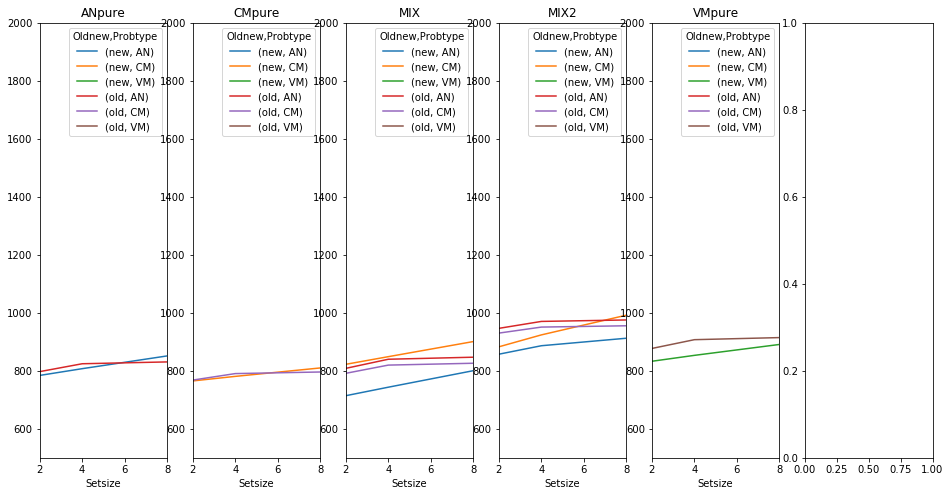

<Figure size 432x288 with 0 Axes>

In [30]:
[alpha["all"],beta["all"],s["all"],
    c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
    Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
    Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
    t0["all"] ,t0["ann"] ,kao,
    F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
    F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
    F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
    F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]] =\
    [1.6205861261288248,  0.2,  0.01,  0.9899960020229178,  0.989997305885351, 
 0.9899845239478274,  0.989999546863487,  0.5356641737231739,  3.336283974964121, 
  -2.931487213477803,  3.155812289719721,  -2.7416418123801662,  3.7427211982968127, 
   -2.7643469613193927,  3.2637502649661827,  -3.437998558909658,  5.792511838173301, 
     -2.205339362112452,  267.71893048345225,  127.8899916115878,  77.4304109668687,  
   0.40622491800888794,  0.4162249180088885,  0.17587240322874048,  0.12183809720918663,  
   0.44179695884733705,  0.11183809720918376,  0.3876738898702132,  0.1155454160837328,  
   0.00012445471474345629,  0.3776738898702135,  0.39767388987021357,  0.1450626700175009,  
   0.00010238745679177577,  0.38527854855677035]  

df_crt_pred = finalRW(df_crt,"crt")
df_err_pred = finalRW(df_err,"err")

all_plot(df_crt_pred,"Pred_cRT",(500,2000))
# all_plot(df_crt_pred,"RT",(5,2000))
# all_plot(df_err_pred,"Pred_error",(0,0.3))
# all_plot(df_err,"Error",(0,0.3))

## all_plot()

In [26]:
def all_plot(df_all,plotwhaty,ylim):
    df_all_err = df_all.copy()
    df_all_agg = df_all_err.groupby(["Oldnew","Setsize","Probtype","FileCondi"]).agg(["mean"])#.apply(lambda x: x)
    df_all_aggnew = df_all_agg.unstack(["Oldnew","Probtype"])
    df_all_aggnew.columns = df_all_aggnew.columns.droplevel([1])

#     df_all_aggnew.index.name = 'Setsize'
    df_all_aggnew.reset_index(inplace=True)
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16,8))
    fig.canvas.set_window_title(plotwhaty)
    line_width = 2.5
    i=0
    names = df_all_aggnew["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name
    plt.figure()
#     plt.title(plotwhaty)
    for iname in names:
        
        df_all_aggnew[df_all_aggnew["FileCondi"]==iname].plot.line(x="Setsize", y=plotwhaty,ax=axes[i],\
                                                                   title=iname,ylim=ylim )
        i+=1
    
    plt.show()
    plt.close()   

In [27]:
# all_plot(df_err_pred,"Pred_error",(0,0.3))
df_err_sub=df_err[df_err["FileCondi"]=="MIX"]

df_err_pred = finalRW(df_err_sub,"err")

df_err_pred

/home/shulai/anaconda3/envs/Lea/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,Oldnew,Setsize,Probtype,Lag,FileCondi,Error,Pred_error
1,1,new,2,AN,0,MIX,0.026667,1.000000e+00
4,4,new,2,CM,0,MIX,0.039583,9.960532e-01
8,8,new,4,AN,0,MIX,0.037344,1.000000e+00
11,11,new,4,CM,0,MIX,0.116034,9.994866e-01
15,15,new,8,AN,0,MIX,0.052632,1.000000e+00
18,18,new,8,CM,0,MIX,0.190776,9.999755e-01
22,22,old,2,AN,1,MIX,0.039841,7.771561e-16
25,25,old,2,AN,2,MIX,0.048193,4.884981e-15
28,28,old,2,CM,1,MIX,0.056225,2.809634e-06
31,31,old,2,CM,2,MIX,0.041667,1.646153e-05


## read fitsel from csv

In [274]:
fitsel

,alpha,beta,s,c,old_crt,new_crt,t0,t0ann,kappa,F_cmoonn,L_cmoonn,Lcmonno,an_oool
0,0.3670763538168613,0.6901624496395286,0.030511443208974746,0.7141440449608176,4.567050226255028,-5.27254062231426,458.81972955449453,503.8383323847754,21.591164515491762,0.25626743273973024,0.2027300573118364,0.19273005737289975,0.17300670320601097
1,0.16865733078282616,2.153480448883181,0.053888485888634916,0.2659479954962367,5.311566553759647,-8.0,694.1731724497188,683.4212451569069,5.0,0.022397885355684977,0.1408385429485826,0.13083854294787226,2.0039075395397897e-14
2,0.44109179601195814,0.8697464865792425,0.028106781472422463,0.5978809971361752,3.9395626284414167,-4.433187020563635,450.9497402738318,506.67618787463596,30.184797386652477,0.17304998442372446,0.1648605670105302,0.1548605670105302,0.08753033597554759
3,0.38461512123995034,0.7379948816129482,0.02887510888904657,0.6793763591243129,4.197148281741437,-4.921275565776636,454.02758473818204,482.28530333218794,25.445199857323708,0.2331477085052058,0.16383758427408834,0.15383758427408833,0.16226896868757185
4,0.38916102280633363,0.6955426229400538,0.031210663063885744,0.8087922522707978,5.0319930423561114,-5.7742421355836395,464.3296063547273,499.7757500096961,17.70782132731559,0.33101075198960617,0.22378928716047236,0.21378928716047568,0.248315623815895
5,0.37199950953863775,0.706688962895521,0.029893522231870383,0.6864945667976983,4.379299673040658,-5.068055645346809,455.82007786991477,500.0419239949218,23.57151810323133,0.23555415140117106,0.18932410444667655,0.1793241044466765,0.15440751987989645
6,0.01 ~ 1.0,0.01 ~ 3.0,0.01 ~ 1.0,0.01 ~ 2.0,1.0 ~ 8.0,-8.0 ~ -1.0,100.0 ~ 800.0,100.0 ~ 800.0,5.0 ~ 100.0,0.0 ~ 2.0,0.0 ~ 2.0,0.0 ~ 2.0,0.0 ~ 2.0


In [400]:
# fitsel = pd.read_csv("11_25_02_36_single_test.csv").iloc[:,1:]

# fitsel = pd.read_csv("11_25_06_33_single_test.csv").iloc[:,1:]

fitsel = pd.read_csv("11_25_13_09_single_test_MIX2(big_change_wssd).csv").iloc[:,1:]
# [alpha["all"], beta["all"], s["all"],
#  c["MIX"], Old_crit["MIX"], New_crit["MIX"], t0["all"],t0["ann"], kao,
#  F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"],
#  F["MIX_AN_oldiold_oldinew"]]=\
# fitsel.iloc[1,:].astype(float).to_list()
# fitsel

## real try **

** 0 91.76239678010586 **


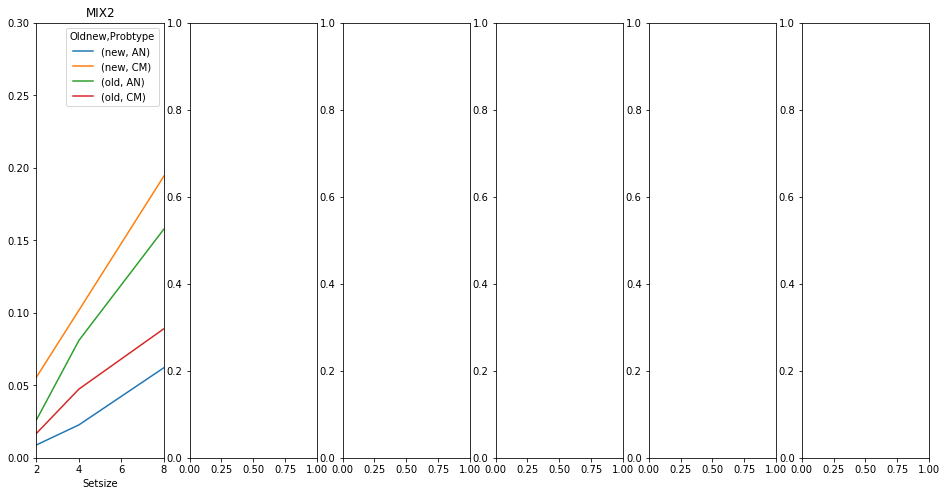

<Figure size 432x288 with 0 Axes>

** 1 87.76247024667843 **


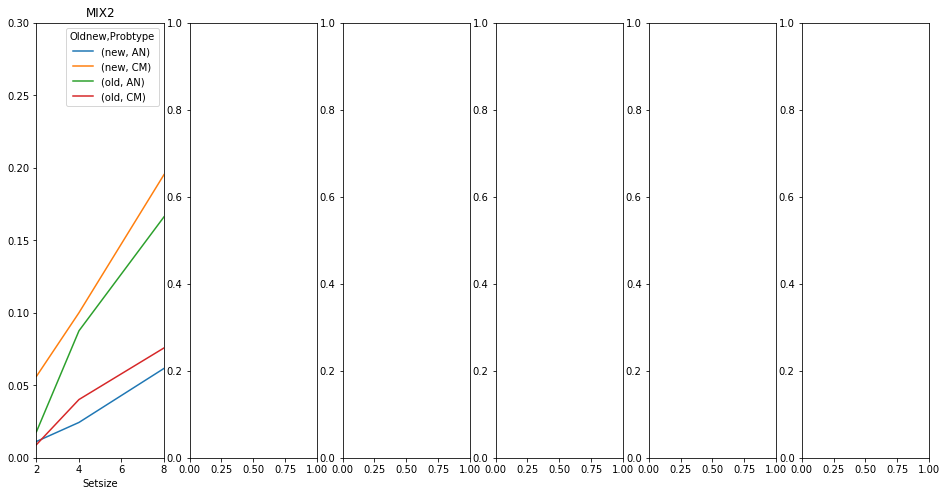

<Figure size 432x288 with 0 Axes>

** 2 87.7624780224324 **


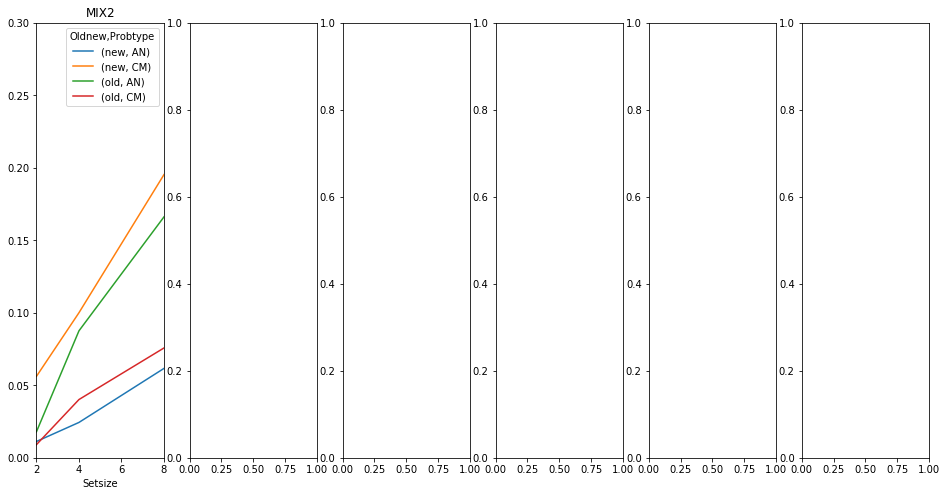

<Figure size 432x288 with 0 Axes>

** 3 87.76191222716223 **


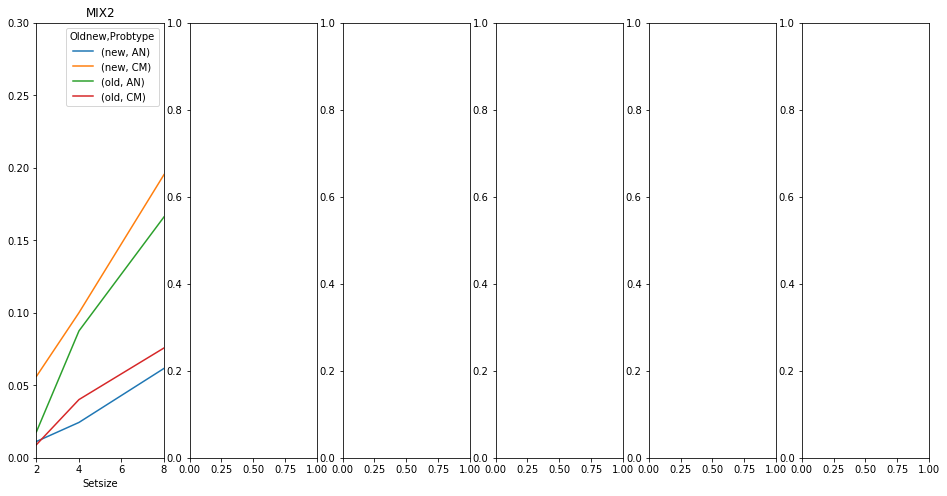

<Figure size 432x288 with 0 Axes>

true


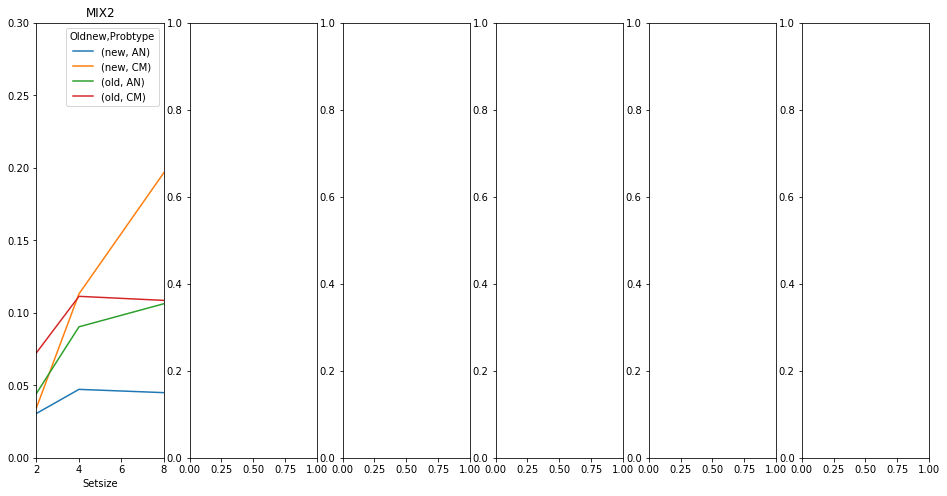

<Figure size 432x288 with 0 Axes>

In [401]:
search_MIX1=0
search_MIX2=1
for i in range(fitsel.shape[0]-1):
    
    if search_MIX1!=1 and search_MIX2!=1:
        [alpha["all"],beta["all"],s["all"],
        c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
        Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
        Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
        F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], 
         L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
        F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"],
         L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]] =\
        fitsel.iloc[i,:fitsel.shape[1]-2].astype(float).to_list()
        
        df_crt_pred = finalRW(df_crt,"crt")
        df_err_pred = finalRW(df_err,"err")
        
    elif search_MIX1==1:
        [alpha["all"], beta["all"], s["all"],
         c["MIX"], Old_crit["MIX"], New_crit["MIX"], t0["all"],t0["ann"], kao,
         F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"],
         F["MIX_AN_oldiold_oldinew"]]=\
        fitsel.iloc[i,:fitsel.shape[1]-2].astype(float).to_list()     
        
        df_crt_sub=df_crt.copy()
        df_crt_sub=df_crt_sub[df_crt_sub["FileCondi"]=="MIX"]
        df_err_sub=df_err.copy()
        df_err_sub=df_err_sub[df_err_sub["FileCondi"]=="MIX"]
        
        df_crt_pred = finalRW(df_crt_sub,"crt")
        df_err_pred = finalRW(df_err_sub,"err")
    elif search_MIX2==1:

        [alpha["all"], beta["all"], s["all"],
         c["MIX2"], Old_crit["MIX2"], New_crit["MIX2"], t0["all"],t0["ann"], kao,
         F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"],
         F["MIX2_AN_oldiold_oldinew"]]=\
        fitsel.iloc[i,:fitsel.shape[1]-2].astype(float).to_list()
                
        df_crt_sub=df_crt.copy()
        df_crt_sub=df_crt_sub[df_crt_sub["FileCondi"]=="MIX2"]
        df_err_sub=df_err.copy()
        df_err_sub=df_err_sub[df_err_sub["FileCondi"]=="MIX2"]
        
        df_crt_pred = finalRW(df_crt_sub,"crt")
        df_err_pred = finalRW(df_err_sub,"err")
        

    print("**",i,fitsel["wssd"][i],"**")
    
    all_plot(df_err_pred,"Pred_error",(0,0.3))
    if i==fitsel.shape[0]-2:
        print("true")
        all_plot(df_err[df_err["FileCondi"]=="MIX2"],"Error",(0,0.3))

** 0 91.76239678010586 **


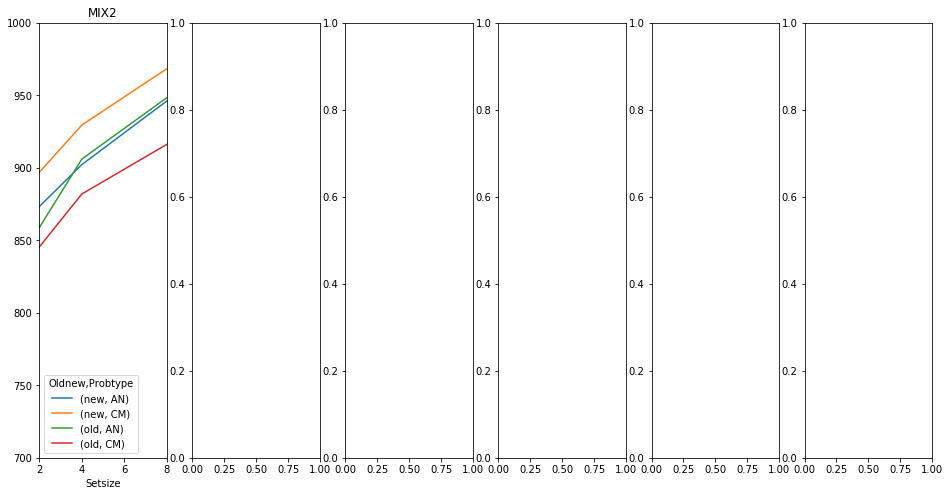

<Figure size 432x288 with 0 Axes>

** 1 87.76247024667843 **


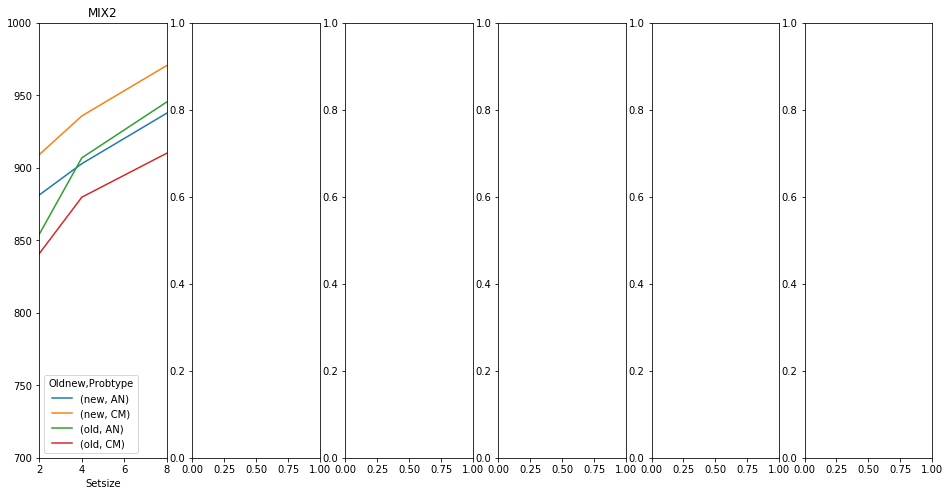

<Figure size 432x288 with 0 Axes>

** 2 87.7624780224324 **


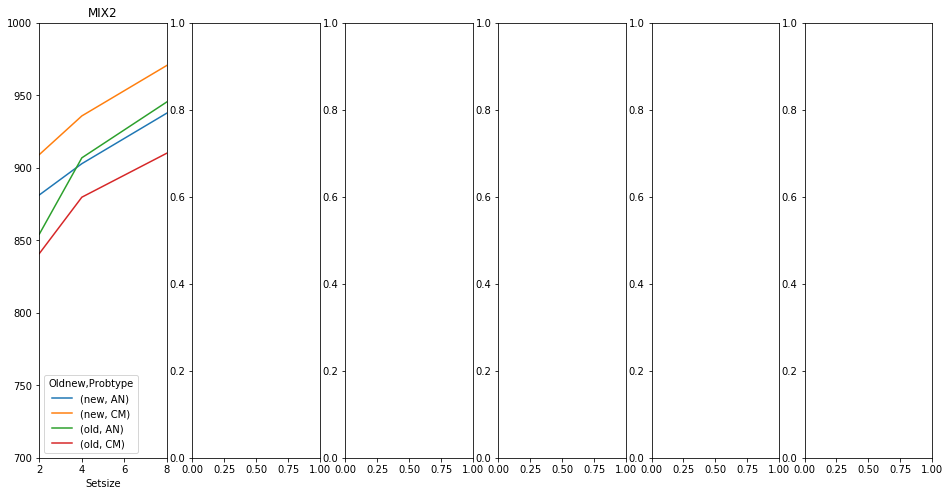

<Figure size 432x288 with 0 Axes>

** 3 87.76191222716223 **


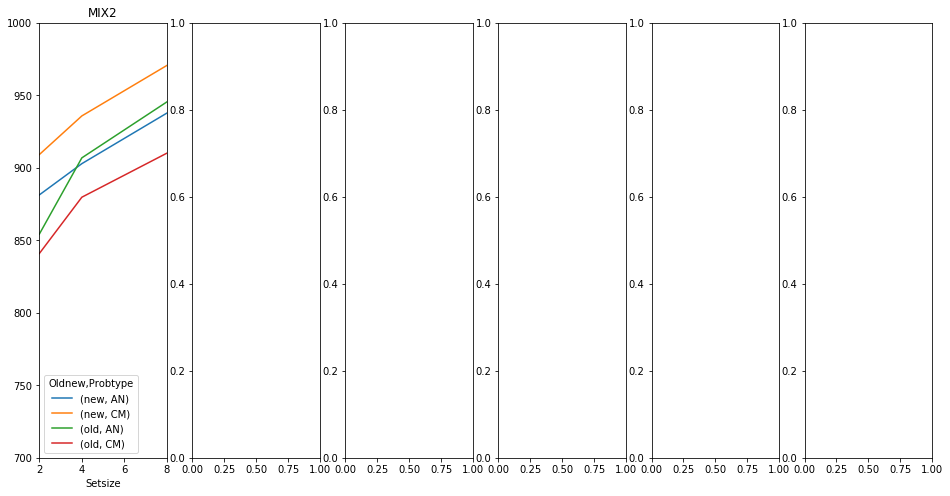

<Figure size 432x288 with 0 Axes>

true


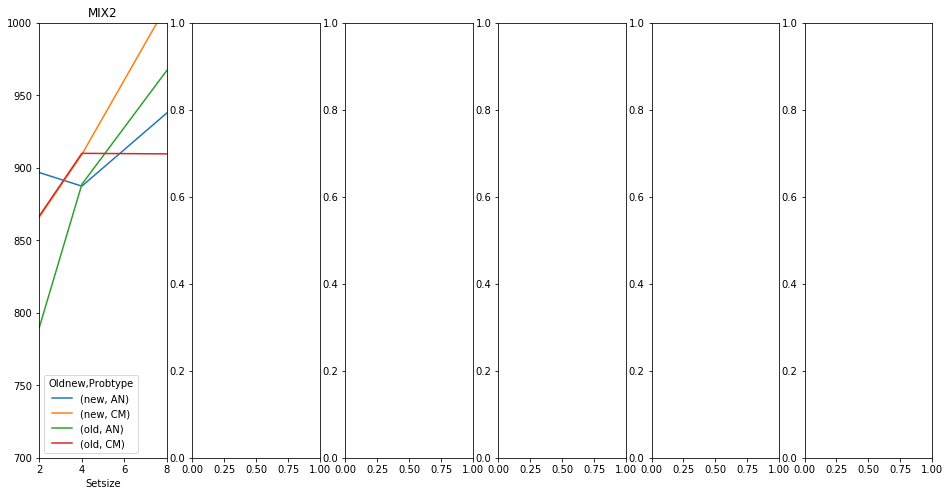

<Figure size 432x288 with 0 Axes>

In [402]:
for i in range(fitsel.shape[0]-1):

    if search_MIX1!=1 and search_MIX2!=1:
        [alpha["all"],beta["all"],s["all"],
        c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
        Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
        Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
        F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], 
         L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
        F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"],
         L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]] =\
        fitsel.iloc[i,:fitsel.shape[1]-2].astype(float).to_list()
        
        df_crt_pred = finalRW(df_crt,"crt")
        df_err_pred = finalRW(df_err,"err")
        
    elif search_MIX1==1:
        [alpha["all"], beta["all"], s["all"],
         c["MIX"], Old_crit["MIX"], New_crit["MIX"], t0["all"],t0["ann"], kao,
         F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"],
         F["MIX_AN_oldiold_oldinew"]]=\
        fitsel.iloc[i,:fitsel.shape[1]-2].astype(float).to_list()

        df_crt_sub=df_crt.copy()
        df_crt_sub=df_crt_sub[df_crt_sub["FileCondi"]=="MIX"]
        df_err_sub=df_err.copy()
        df_err_sub=df_err_sub[df_err_sub["FileCondi"]=="MIX"]
        
        df_crt_pred = finalRW(df_crt_sub,"crt")
        df_err_pred = finalRW(df_err_sub,"err")
        
    elif search_MIX2==1:

        [alpha["all"], beta["all"], s["all"],
         c["MIX2"], Old_crit["MIX2"], New_crit["MIX2"], t0["all"],t0["ann"], kao,
         F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"],
         F["MIX2_AN_oldiold_oldinew"]]=\
        fitsel.iloc[i,:fitsel.shape[1]-2].astype(float).to_list()
                
        df_crt_sub=df_crt.copy()
        df_crt_sub=df_crt_sub[df_crt_sub["FileCondi"]=="MIX2"]
        df_err_sub=df_err.copy()
        df_err_sub=df_err_sub[df_err_sub["FileCondi"]=="MIX2"]
        
        df_crt_pred = finalRW(df_crt_sub,"crt")
        df_err_pred = finalRW(df_err_sub,"err")
        
    print("**",i,fitsel["wssd"][i],"**")
    all_plot(df_crt_pred,"Pred_cRT",(700,1000))
#     all_plot(df_crt_pred,"RT",(5,2000))
#     all_plot(df_err_pred,"Pred_error",(0,0.3))
    if i==fitsel.shape[0]-2:
        print("true")
        all_plot(df_crt[df_crt["FileCondi"]=="MIX2"],"RT",(700,1000))

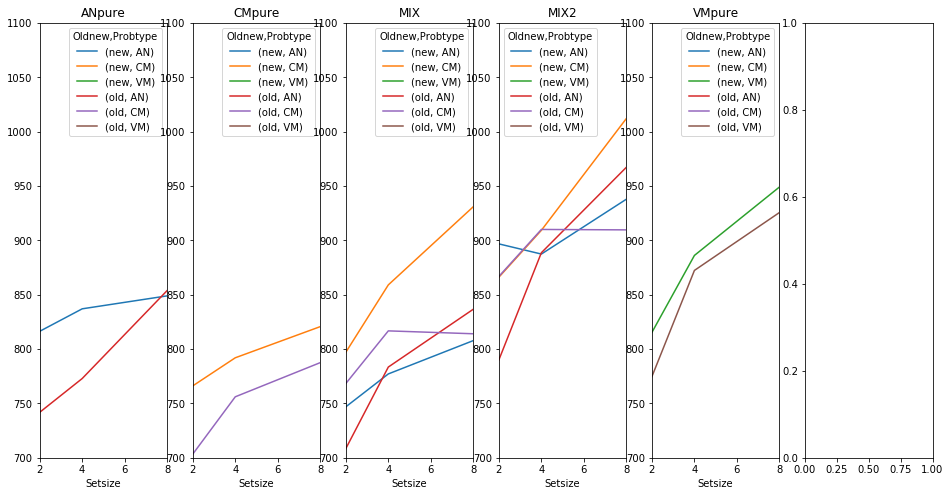

<Figure size 432x288 with 0 Axes>

In [50]:
all_plot(df_crt_pred,"Pred_cRT",(700,1100))
all_plot(df_crt_pred,"RT",(700,1100))

In [224]:
source("functions_fromr.r")

In [361]:
%get df_crt_pred --from Python3
%get df_err_pred --from Python3
%get df0 --from Python3

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


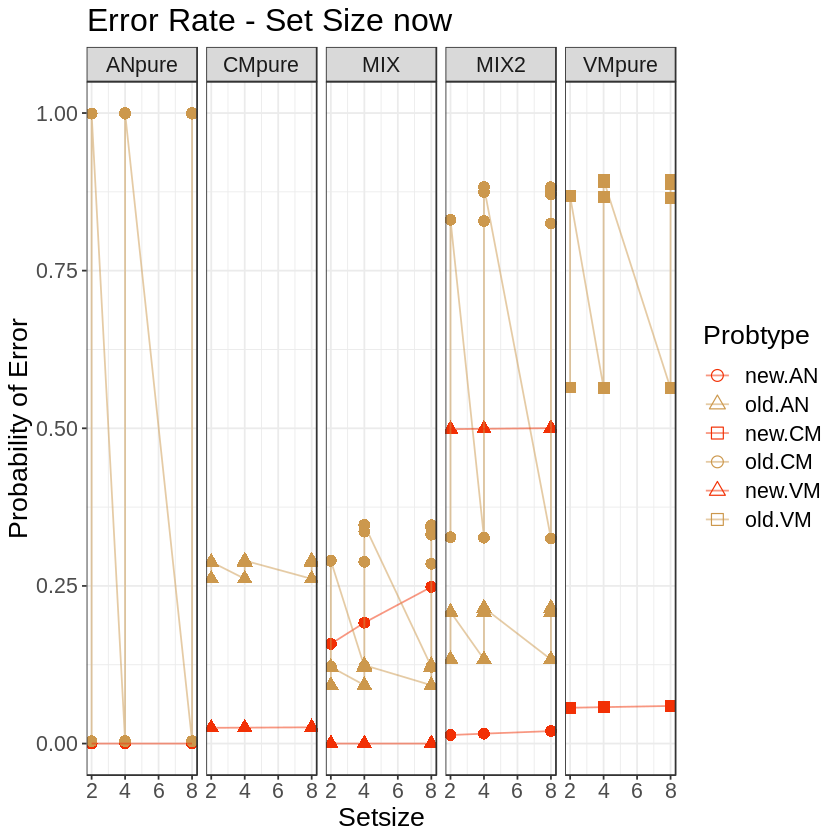

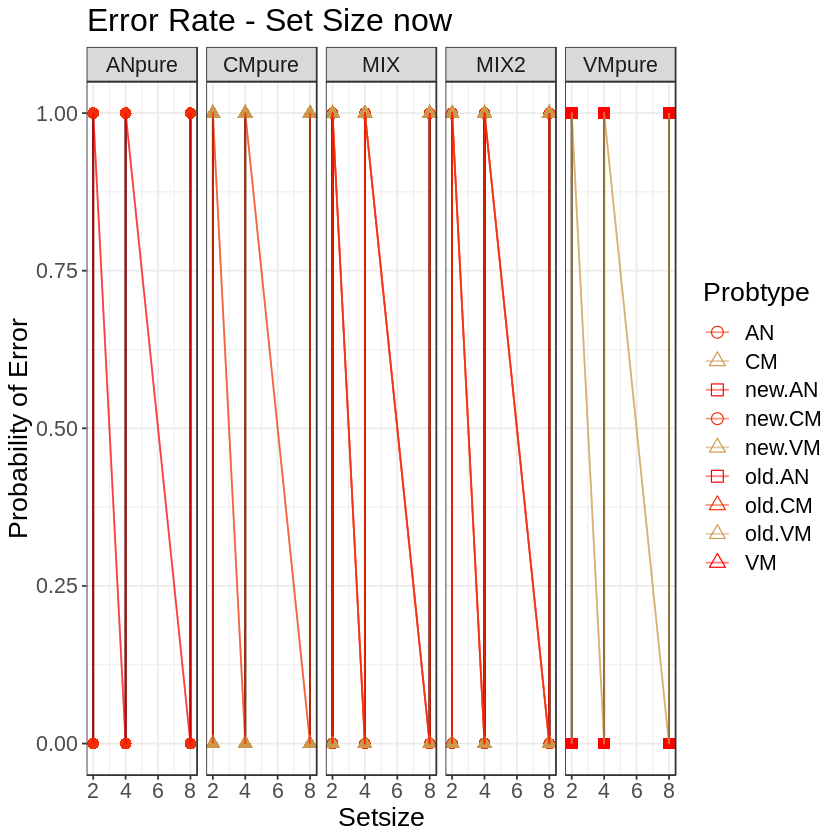

In [382]:
p.ER.pred=function(d,tit){
    override.shape = c(1,2,0,1,2,0)
  p=ggplot(data=d,aes(Setsize,Pred_error))+
    geom_point(aes(color=interaction(Oldnew,Probtype),shape=as.factor(Probtype),group=Oldnew),size=3)+
      geom_line(aes(color=interaction(Oldnew,Probtype),#linetype=as.factor(FileCondi),
                    group=interaction(Oldnew,Probtype)),lwd=0.5,alpha=0.5)+
      scale_color_manual(name="Probtype",
                         values=c(rep(c("#F23005","#CC984D"),3)))+
    scale_shape_discrete(guide=FALSE)+
    ggtitle(paste("Error Rate - Set Size",tit))+
    theme_bw()+
    theme(text=element_text(size=16))+
    ylim(0,0.25)+
    guides(colour = guide_legend(override.aes=list(shape=override.shape)))+
    facet_wrap(FileCondi~.,ncol=6)+
    scale_y_continuous("Probability of Error")
  return(p)
}
p.ER.org=function(d,tit){
    override.shape = c(1,2,0,1,2,0,2,2,2)
  d0= d 
  dase= d %>% group_by(FileCondi,Oldnew,Setsize,Probtype,Correctness) %>%
    dplyr::summarize(Error=mean(Correctness),se=sd(Correctness)/sqrt(n()))
  # print(dase)
  da1se=dase
  p=ggplot(data=da1se,aes(Setsize,Error))+
    geom_errorbar(aes(ymin=(Error-se), ymax=(1-Correctness)+se), width=.2,
                  position=position_dodge(.9),alpha=0.5) +
    geom_point(aes(color=Probtype,shape=as.factor(Probtype),group=Oldnew),size=3)+
      geom_line(aes(color=interaction(Oldnew,Probtype),#linetype=as.factor(FileCondi),
                    group=interaction(Oldnew,Probtype)),lwd=0.5,alpha=0.5)+
      scale_color_manual(name="Probtype",
                         values=c(rep(c("#F23005","#CC984D","red"),3)))+
    scale_shape_discrete(guide=FALSE)+
    ggtitle(paste("Error Rate - Set Size",tit))+
    theme_bw()+
    theme(text=element_text(size=16))+
    ylim(0,0.25)+
    guides(colour = guide_legend(override.aes=list(shape=override.shape)))+
    facet_wrap(FileCondi~.,ncol=6)+
    scale_y_continuous("Probability of Error")#+
#     coord_fixed(ratio=0.08)
  return(p)
}
p.ER.pred(df_err_pred,"now")
p.ER.org(df0,"now")